In [1]:

import pandas as pd
import numpy as np
import os
import json
import pickle
import glob

from datetime import datetime

C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def get_prolific_pid(x):
    d = json.loads(x)
    if "PROLIFIC_PID" not in d:
        return ""
    return d["PROLIFIC_PID"]

def set_iteration(row):
    if row.interaction_type == "iteration-started" or row.interaction_type == "iteration-ended":
        row['iteration'] = json.loads(row.data)['iteration']
    else:
        row['iteration'] = None
    return row

In [3]:
df_interaction = pd.read_json("data/raw_final/interaction-export.json", encoding='utf-8')
df_interaction_raw = df_interaction.copy()

df_interaction = df_interaction.apply(set_iteration, axis=1)
df_interaction['iteration'] = df_interaction.groupby(['participation'], sort=False, group_keys=False)['iteration'].apply(lambda x: x.ffill())
df_interaction = df_interaction.dropna()
df_interaction.iteration = df_interaction.iteration.astype(int)

df_participation = pd.read_json("data/raw_final/participation-export.json", encoding='utf-8')
df_participation.loc[:, "prolific_pid"] = df_participation.extra_data.map(get_prolific_pid)
df_participation = df_participation[df_participation.time_finished.notna()]
df_participation = df_participation[df_participation.participant_email != "a@a.a"]
df_participation = df_participation[df_participation.time_finished.notna()]
df_participation = df_participation[df_participation.user_study_id >= 4]


df_interaction = df_interaction[df_interaction.participation.isin(df_participation.id)]

In [4]:
final_questionnaire = df_interaction[df_interaction.interaction_type == 'final-questionnaire']
print(final_questionnaire.shape)
def set_failed(row):
    d = json.loads(row.data)
    hits = 0
    hits += int(d['qs1']) == 1
    hits += int(d['qs2']) == -2
    hits += int(d['qs3']) <= 1
    row['failed'] = hits <= 1
    row['hits'] = hits
    return row
final_questionnaire = final_questionnaire.apply(set_failed, axis=1)
final_questionnaire = final_questionnaire.loc[final_questionnaire.failed == False]
print(final_questionnaire.shape)

(108, 6)
(106, 8)


In [5]:
df_interaction = df_interaction[df_interaction.participation.isin(final_questionnaire.participation)]

In [6]:
df_interaction.shape

(83413, 6)

In [7]:
def create_selections_csv(df_interaction):
    df_result = pd.DataFrame(columns = [
        "userId",
        "movieId",
        "timestamp",
        "session",
        "rank",
        "algorithm"
    ])
    
    df_selections = df_interaction[df_interaction.interaction_type == "selected-item"]
    for _, row in df_selections.iterrows():
        d = json.loads(row.data)
        new_row = [
            row.participation,
            d["selected_item"]["movie_idx"],
            int(datetime.fromisoformat(row.time).timestamp()),
            row.iteration,
            d["selected_item"]["rank"],
            d["selected_item"]["variant_name"]
        ]
        df_result = pd.concat([df_result, pd.DataFrame([new_row], columns=df_result.columns)], ignore_index=True)
    return df_result


def create_impressions_csv(df_interaction):
    df_result = pd.DataFrame(columns = [
        "userId",
        "movieId",
        "timestamp",
        "session",
        "rank",
        "algorithm",
        "actually_shown",
        "relevanceGain",
        "diversityGain",
        "noveltyGain"
    ])
    
    # load beta supports from separate file #
    beta_supports = pd.read_csv("beta_supports.csv")
    beta_supports.userId = beta_supports.userId.astype(int)
    beta_supports.movieId = beta_supports.movieId.astype(int)
    beta_supports.session = beta_supports.session.astype(int)
    
    df_iteration_starts = df_interaction[df_interaction.interaction_type == "iteration-started"]
    for _, row in df_iteration_starts.iterrows():
        d = json.loads(row.data)
        
        actually_shown_algorithms = set()
        for x in d["algorithm_assignment"].values():
            if x["order"] >= 0:
                actually_shown_algorithms.add(x["name"])
        
        for algo, algo_data in d["movies"].items():
            was_shown = True
            if algo not in actually_shown_algorithms:
                was_shown = False

            for rank, movie in enumerate(algo_data["movies"]):
                timestamp = int(datetime.fromisoformat(row.time).timestamp())
                
                if algo == "BETA":
                    # Get supports from different place
                    rw = beta_supports[(beta_supports.userId == int(row.participation)) & \
                                       (beta_supports.session == int(row.iteration)) & \
                                       (beta_supports.movieId == int(movie["movie_idx"]))]
                    
                    assert rw.shape[0] == 1
                    relGain = rw.iloc[0].relevanceSupport
                    divGain = rw.iloc[0].diversitySupport
                    novGain = rw.iloc[0].noveltySupport
                else:
                    relGain = movie["support"]["relevance"]
                    divGain = movie["support"]["diversity"]
                    novGain = movie["support"]["novelty"]
                
                new_row = [
                    row.participation,
                    movie["movie_idx"],
                    timestamp,
                    row.iteration,
                    rank,
                    algo,
                    was_shown,
                    relGain,
                    divGain,
                    novGain
                ]
                df_result = pd.concat([df_result, pd.DataFrame([new_row], columns=df_result.columns)], ignore_index=True)                                                            
                
    return df_result


def create_weights_csv(df_interaction):
    df_result = pd.DataFrame(columns = [
        "userId",
        "relevanceWeight",
        "diversityWeight",
        "noveltyWeight",
        "timestamp",
        "iteration"
    ])
    
    df_iteration_starts = df_interaction[df_interaction.interaction_type == "iteration-started"]
    for _, row in df_iteration_starts.iterrows():
        d = json.loads(row.data)
        
        shown_moo = None
        for x in d["algorithm_assignment"].values():
            if x["order"] >= 0 and x["name"] in {"DELTA", "GAMMA"}:
                shown_moo = x["name"]
                break
        
        [rel, div, nov] = d["weights"][shown_moo]
        
        new_row = [
            row.participation,
            rel,
            div,
            nov,
            int(datetime.fromisoformat(row.time).timestamp()),
            row.iteration
        ]
        df_result = pd.concat([df_result, pd.DataFrame([new_row], columns=df_result.columns)], ignore_index=True)
        
    return df_result


In [8]:
dfSelections = create_selections_csv(df_interaction)
dfSelections.to_csv("selections.csv", index=False)

In [9]:
dfImpressions = create_impressions_csv(df_interaction)
dfImpressions.to_csv("impressions.csv", index=False)

<ipython-input-7-009f3440a49b>:90: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_result = pd.concat([df_result, pd.DataFrame([new_row], columns=df_result.columns)], ignore_index=True)


In [230]:
dfWeights = create_weights_csv(df_interaction)
dfWeights.to_csv("weights.csv", index=False)

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='rank', ylabel='session'>

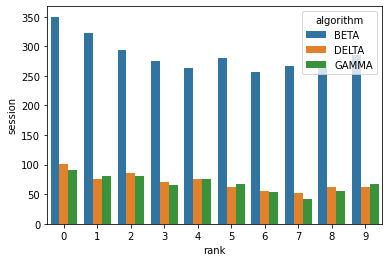

In [11]:
rankSelections = dfSelections.groupby(["rank","algorithm"])[["session"]].count().reset_index()
sns.barplot(rankSelections, hue="algorithm", x="rank", y="session")

- gradual decrease in selections, but not as strong as expected

In [12]:
#all items that were (would be) shown by some algorithm in that particular session and were selected (no matter if the selection was made on that particular algorithm or not)
dfEnhancedSelections = dfImpressions.set_index(["userId","movieId","session"]).join(dfSelections.set_index(["userId","movieId","session"]), rsuffix="_selection", how="inner")
dfEnhancedSelections.shape, dfSelections.shape

((6218, 10), (4242, 6))

In [123]:
dfShownSelections = dfEnhancedSelections.loc[dfEnhancedSelections.actually_shown == True]
dfShownImpressions = dfImpressions.loc[dfImpressions.actually_shown == True]
dfShownSelections.shape

(5074, 10)

# Selection ratios: Beta >> Delta > Gamma

In [103]:
dfShownSelections.groupby("algorithm")[["actually_shown"]].count() / dfShownImpressions.groupby("algorithm")[["actually_shown"]].count()

actually_shown
algorithm                
BETA             0.369683
DELTA            0.262441
GAMMA            0.190588

- probably the main possible argument for paper: although volumes of selections are lower for MORS, selected items are much more novel and diverse

In [104]:
dfShownSelections.groupby("algorithm")[["relevanceGain","diversityGain","noveltyGain"]].mean()

relevanceGain  diversityGain  noveltyGain
algorithm                                           
BETA            0.974350       0.245958     0.634858
DELTA           0.942816       0.514793     0.718972
GAMMA           0.909848       0.688914     0.816158

In [105]:
dfShownImpressions.groupby("algorithm")[["relevanceGain","diversityGain","noveltyGain"]].mean()

relevanceGain  diversityGain  noveltyGain
algorithm                                           
BETA            0.979944       0.251035     0.652702
DELTA           0.912636       0.659323     0.789506
GAMMA           0.874888       0.787263     0.849241

- users largely follow the distribution of impressions, but not as much towards its extreme values. 
  - This is mostly true for diversity and novelty marginal gains and also partially to relevance and BETA alg.
  - seemingly, both diversity and novelty were over-powered in MORS cases

### A bit more details on the above tables: distribution of selections and impressions w.r.t. marginal gains

<AxesSubplot:xlabel='noveltyGain', ylabel='Density'>

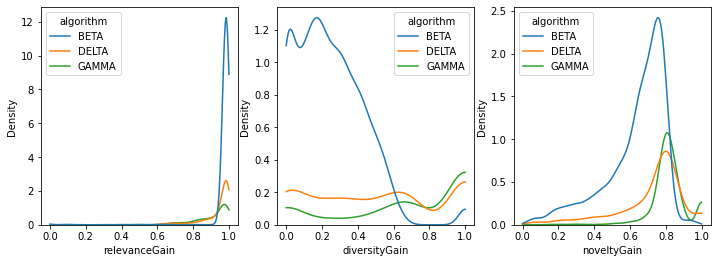

In [106]:
fig,ax = plt.subplots(1,3, figsize=(12,4))
sns.kdeplot(dfShownSelections, x="relevanceGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[0])
sns.kdeplot(dfShownSelections, x="diversityGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[1])
sns.kdeplot(dfShownSelections, x="noveltyGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[2])

<AxesSubplot:xlabel='noveltyGain', ylabel='Density'>

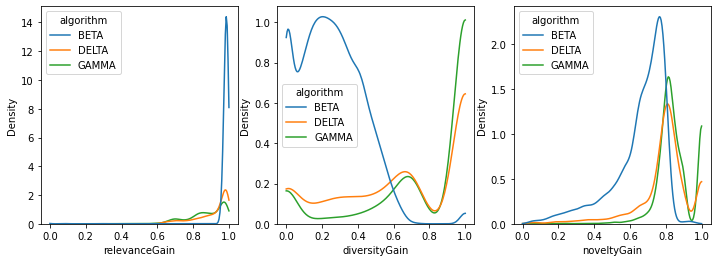

In [107]:
fig,ax = plt.subplots(1,3, figsize=(12,4))
sns.kdeplot(dfShownImpressions, x="relevanceGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[0])
sns.kdeplot(dfShownImpressions, x="diversityGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[1])
sns.kdeplot(dfShownImpressions, x="noveltyGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[2])

<ipython-input-108-9ca31be4cd51>:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(dfShownSelections, x="relevanceGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[0], linestyle='--', palette=sns.color_palette())
<ipython-input-108-9ca31be4cd51>:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(dfShownSelections, x="diversityGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[1], linestyle='--', palette=sns.color_palette())
<ipython-input-108-9ca31be4cd51>:4: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(dfShownSelections, x="noveltyGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[2], linestyle='--', palette=sns.color_palette())
<ipython-input-108-9ca31be4cd51>:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(df

<AxesSubplot:xlabel='noveltyGain', ylabel='Density'>

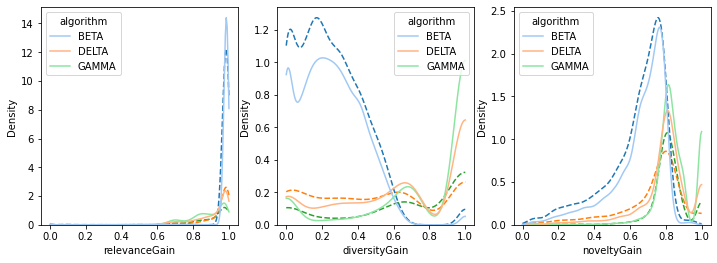

In [108]:
fig,ax = plt.subplots(1,3, figsize=(12,4))
sns.kdeplot(dfShownSelections, x="relevanceGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[0], linestyle='--', palette=sns.color_palette())
sns.kdeplot(dfShownSelections, x="diversityGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[1], linestyle='--', palette=sns.color_palette())
sns.kdeplot(dfShownSelections, x="noveltyGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[2], linestyle='--', palette=sns.color_palette())

sns.kdeplot(dfShownImpressions, x="relevanceGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[0], palette=sns.color_palette("pastel"))
sns.kdeplot(dfShownImpressions, x="diversityGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[1], palette=sns.color_palette("pastel"))
sns.kdeplot(dfShownImpressions, x="noveltyGain", hue="algorithm", common_norm=True, clip=(0,1), ax=ax[2], palette=sns.color_palette("pastel"))

In [109]:
dfShownSelections.reset_index().groupby(["userId","algorithm"])

## Significance tests

In [110]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of Beta algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="BETA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="BETA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="BETA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.algorithm=="BETA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="BETA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="BETA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="BETA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.algorithm=="BETA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="BETA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="BETA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="BETA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.algorithm=="BETA"]["noveltyGain"]))


Results of Beta algorithm for impressions vs. selections marginal gains
Relevance: 0.9799435591234501 0.9743499411907096 Ttest_indResult(statistic=4.086901666602345, pvalue=4.401027064632693e-05)
Diversity: 0.25103503298516444 0.24595803698915003 Ttest_indResult(statistic=1.3487483243269816, pvalue=0.17744402534175055)
Novelty: 0.6527021605598281 0.6348584868205321 Ttest_indResult(statistic=5.456226054961054, pvalue=4.9630429580719664e-08)


- for Beta, significantly lower values w.r.t. relevance and novelty, while no stat.sign. difference in diversity

In [111]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of DELTA algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="DELTA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="DELTA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="DELTA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.algorithm=="DELTA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="DELTA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="DELTA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="DELTA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.algorithm=="DELTA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="DELTA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="DELTA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="DELTA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.algorithm=="DELTA"]["noveltyGain"]))


Results of DELTA algorithm for impressions vs. selections marginal gains
Relevance: 0.912635751173709 0.9428161896243292 Ttest_indResult(statistic=-9.819010998393434, pvalue=1.4421967485950992e-22)
Diversity: 0.6593228169014084 0.5147926654740608 Ttest_indResult(statistic=11.972671709256096, pvalue=1.2801848279664223e-32)
Novelty: 0.7895064788732395 0.7189723613595707 Ttest_indResult(statistic=12.759516791247188, pvalue=9.374765413409694e-37)


In [112]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of GAMMA algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="GAMMA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="GAMMA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="GAMMA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.algorithm=="GAMMA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="GAMMA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="GAMMA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="GAMMA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.algorithm=="GAMMA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.algorithm=="GAMMA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.algorithm=="GAMMA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.algorithm=="GAMMA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.algorithm=="GAMMA"]["noveltyGain"]))


Results of GAMMA algorithm for impressions vs. selections marginal gains
Relevance: 0.8748875529411765 0.9098481481481481 Ttest_indResult(statistic=-8.319382487409356, pvalue=1.1256289311719197e-16)
Diversity: 0.7872631999999999 0.6889143209876544 Ttest_indResult(statistic=7.638281158178592, pvalue=2.6162728510242245e-14)
Novelty: 0.8492407764705882 0.8161576543209877 Ttest_indResult(statistic=8.481784489581264, pvalue=2.877366487523007e-17)


- for both GAMMA and Delta, significantly higher values w.r.t. relevance, while lower values w.r.t. diversity and novelty

### Checking on the rank positions of selected items

<AxesSubplot:xlabel='rank', ylabel='count'>

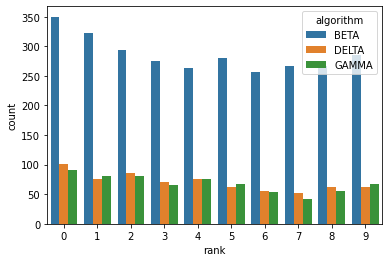

In [113]:
import seaborn as sns
sns.countplot(dfSelections, x="rank", hue="algorithm")

<AxesSubplot:xlabel='rank', ylabel='count'>

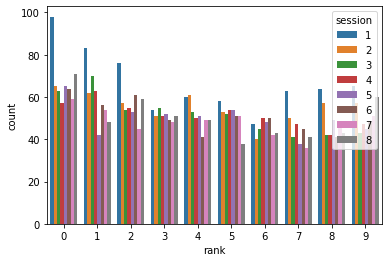

In [114]:
sns.countplot(dfSelections, x="rank", hue="session")

- overall, fairly stable volume of selections per rank for all types of algorithms; seemingly more substantial drop in the first iteration than in the subsequent ones
- can be an artefact of the lack of choices in the later sessions

# Novelty and Diversity calculations

In [133]:
# Objectives / metrics
# Objectives / metrics
import functools
from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer, label_binarize

rating_matrix = np.load("rating_matrix_backup.npy")
movies_info_df = pd.read_csv("movies_df_backup.csv")
movies_info_df.year = movies_info_df.year.astype(int)
movies_info_df = movies_info_df.set_index("movieId")
similarity_matrix = np.load("similarity_matrix_backup.npy")
distance_matrix = 1.0 - similarity_matrix
ratings = pd.read_csv("data/ratings.csv")
indexedRatings = ratings.set_index(["userId", "session","movieId"])

with open("movie_index_to_id.pckl", "rb") as f:
    movie_index_to_id = pickle.load(f)

    
#@functools.cache
def get_all_genres():
    all_genres = set()
    for row in movies_info_df.genres.unique():
        genres = row.split("|")
        all_genres = all_genres.union(genres)
    return all_genres

# !!!!!!!!!!!!
# Multigenre means that multiple genres assigned to a single movie are treated as a single genre

#@functools.cache
def get_all_multi_genres():
    return movies_info_df.genres.unique()

# Recall@K
# Rec_list is the list with recommendations
# All user selections are user selections
def recall(rec_list, all_user_selections):
    rec_list_correct = [x for x in rec_list if x in all_user_selections]
    if min(len(all_user_selections), len(rec_list)) == 0:
        return 0.0
    return len(rec_list_correct) / min(len(all_user_selections), len(rec_list))

# Return all genres that given movie has
def get_item_genres(item_index):
    
    item_id = movie_index_to_id[item_index]
    genres = movies_info_df.loc[item_id].genres.split("|")
    return genres

def get_item_multi_genres(item_index):
    item_id = movie_index_to_id[item_index]
    return movies_info_df.loc[item_id].genres

# Return all genres that all movies in the recommendation list have altogether (union over their genres)
def get_list_genres(rec_list, get_item_genres_f):
    all_genres = set()
    for item in rec_list:
        all_genres = all_genres.union(get_item_genres_f(item))
    return all_genres

def topic_coverage(rec_list, get_item_genres_f, get_all_genres_f):
    rec_list_genres = get_list_genres(rec_list, get_item_genres_f)

    return len(rec_list_genres) / len(get_all_genres_f())

def collaborative_diversity(item_a, item_b):
    if item_b is None:
        return distance_matrix[item_a].sum() / (distance_matrix.shape[0] - 1)
    return distance_matrix[item_a, item_b]

def content_based_diversity(item_a, item_b):
    if item_b is None:
        return 0.0
    inpt = [list(get_item_genres(item_a)), list(get_item_genres(item_b))]
    res = binarizer.fit_transform(inpt)
    cos_sim = (cosine_similarity(res[0], res[1]) + 1) / 2 # Convert from [-1, 1] to [0, 1]
    return 1 - cos_sim # Convert to distance


def content_based_diversity_multigenre(item_a, item_b):
    if item_b is None:
        return 0.0    
    res = label_binarize([get_item_multi_genres(item_a), get_item_multi_genres(item_b)], classes=get_all_multi_genres())
    cos_sim = (cosine_similarity(res[0], res[1]) + 1) / 2 # Convert from [-1, 1] to [0, 1]
    return 1 - cos_sim # Convert to distance

def inverse_popularity(item):
    return (-1 * (np.sum(rating_matrix > 0.0, axis=0) / rating_matrix.shape[0]))[item]
    
def get_item_year(item):
    item_id = movie_index_to_id[item]
    return movies_info_df.loc[item_id].year
    
def temporal_novelty(items):
    x = year_cdf.transform(np.array([get_item_year(item) for item in items]).reshape(-1, 1))
    return sum(x) / len(x)
    
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def get_mean_relevance(rec_list, user, session):
    idx = list(zip([user]*len(rec_list),[session]*len(rec_list),rec_list))
    idxValidity = [i in indexedRatings.index for i in idx]
    idx = np.array(idx)[idxValidity].tolist()
    
    return indexedRatings.loc[idx,"rawRating"].mean()

def list_novelty(rec_list, nov_func):
    assert len(rec_list) > 0
    
    n = len(rec_list)
    nov = 0    
    for i in range(n):
        nov += nov_func(rec_list[i])
    return nov / n
    
def intra_list_diversity(rec_list, div_func):
    assert len(rec_list) > 0
    n = len(rec_list)
    div = 0
    
    if n == 1:
        return div_func(rec_list[0], None) # Overload to calculate mean diversity of an item
    
    for i in range(n):
        for j in range(i): 
            div += div_func(rec_list[i], rec_list[j])
    return div / ((n - 1) * n / 2)

year_cdf = QuantileTransformer().fit(movies_info_df.year.values.reshape(-1, 1))
binarizer = MultiLabelBinarizer(classes=list(get_all_genres()))

In [145]:
#takes couple minutes to calculate
dfShownImpressions["movieId"] = dfShownImpressions["movieId"].astype(int)

dfGroupedImpressions = dfShownImpressions.groupby(["userId","session","algorithm"])["movieId"].apply(list).reset_index()
collDiv = []
cbDiv = []
cbDivMG = []
intNov = []
tempNov = []
for idx, row in dfGroupedImpressions.iterrows():
    collDiv.append(intra_list_diversity(row["movieId"],collaborative_diversity))
    cbDiv.append(intra_list_diversity(row["movieId"],content_based_diversity))
    cbDivMG.append(intra_list_diversity(row["movieId"],content_based_diversity_multigenre))
    intNov.append(list_novelty(row["movieId"],inverse_popularity))
    tempNov.append(temporal_novelty(row["movieId"])[0])
    
dfGroupedImpressions["collDiv"] = collDiv
dfGroupedImpressions["cbDiv"] = cbDiv
dfGroupedImpressions["intNov"] = intNov
dfGroupedImpressions["tempNov"] = tempNov
dfGroupedImpressions["cbDivMG"] = cbDivMG

<ipython-input-145-4ba94a55c167>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfShownImpressions["movieId"] = dfShownImpressions["movieId"].astype(int)


In [146]:
relevance = []
for idx, row in dfGroupedImpressions.iterrows():
    relevance.append(get_mean_relevance(row["movieId"],row["userId"],row["session"]))   
dfGroupedImpressions["relevance"] = relevance

dfGroupedImpressions

userId  session algorithm  \
0         60        1      BETA   
1         60        1     GAMMA   
2         60        2      BETA   
3         60        2     GAMMA   
4         60        3      BETA   
...      ...      ...       ...   
1691     185        6     DELTA   
1692     185        7      BETA   
1693     185        7     DELTA   
1694     185        8      BETA   
1695     185        8     DELTA   

                                                movieId   collDiv     cbDiv  \
0     [1595, 1489, 1423, 1359, 1339, 1455, 1860, 145...  0.890129  0.169690   
1     [1856, 1793, 1816, 1720, 1833, 1292, 1339, 148...  0.969161  0.233497   
2     [1756, 1702, 1434, 1726, 1573, 1494, 1428, 162...  0.914607  0.391049   
3     [1701, 1756, 1703, 1769, 1616, 1633, 1555, 161...  0.998568  0.316272   
4     [1715, 1885, 1797, 1402, 1497, 1454, 1676, 171...  0.911371  0.415268   
...                                                 ...       ...       ...   
1691  [1827, 1713, 1553, 1790, 1610, 1617, 1768, 173...  0.994839  0.395479   
1692  [1226, 1107, 1511, 1304, 1166, 1216, 1108, 665...  0.897384  0.348503   
1693  [1759, 1511, 1434, 1647, 1620, 1320, 1824, 182...  1.000000  0.373505   
1694  [1163, 1342, 258, 1326, 1106, 1386, 1084, 679,...  0.854123  0.369580   
1695  [1581, 1734, 1556, 1605, 1930, 1274, 1580, 160...  1.000000  0.398582   

        intNov   tempNov   cbDivMG  relevance  
0    -0.027569  0.838739  0.322222   1.548370  
1    -0.003800  0.888288  0.333333   1.390141  
2    -0.008679  0.900901  0.477778   2.008837  
3    -0.000848  1.000000  0.355556   1.319438  
4    -0.007589  0.888288  0.488889   1.976296  
...        ...       ...       ...        ...  
1691 -0.000705  1.000000  0.488889   0.762308  
1692 -0.021247  0.616216  0.477778   1.678634  
1693 -0.001608  0.919369  0.488889   0.698755  
1694 -0.035246  0.538739  0.500000   1.579908  
1695 -0.001806  0.962913  0.488889   0.841727  

[1696 rows x 10 columns]

In [147]:
dfGroupedImpressions

userId  session algorithm  \
0         60        1      BETA   
1         60        1     GAMMA   
2         60        2      BETA   
3         60        2     GAMMA   
4         60        3      BETA   
...      ...      ...       ...   
1691     185        6     DELTA   
1692     185        7      BETA   
1693     185        7     DELTA   
1694     185        8      BETA   
1695     185        8     DELTA   

                                                movieId   collDiv     cbDiv  \
0     [1595, 1489, 1423, 1359, 1339, 1455, 1860, 145...  0.890129  0.169690   
1     [1856, 1793, 1816, 1720, 1833, 1292, 1339, 148...  0.969161  0.233497   
2     [1756, 1702, 1434, 1726, 1573, 1494, 1428, 162...  0.914607  0.391049   
3     [1701, 1756, 1703, 1769, 1616, 1633, 1555, 161...  0.998568  0.316272   
4     [1715, 1885, 1797, 1402, 1497, 1454, 1676, 171...  0.911371  0.415268   
...                                                 ...       ...       ...   
1691  [1827, 1713, 1553, 1790, 1610, 1617, 1768, 173...  0.994839  0.395479   
1692  [1226, 1107, 1511, 1304, 1166, 1216, 1108, 665...  0.897384  0.348503   
1693  [1759, 1511, 1434, 1647, 1620, 1320, 1824, 182...  1.000000  0.373505   
1694  [1163, 1342, 258, 1326, 1106, 1386, 1084, 679,...  0.854123  0.369580   
1695  [1581, 1734, 1556, 1605, 1930, 1274, 1580, 160...  1.000000  0.398582   

        intNov   tempNov   cbDivMG  relevance  
0    -0.027569  0.838739  0.322222   1.548370  
1    -0.003800  0.888288  0.333333   1.390141  
2    -0.008679  0.900901  0.477778   2.008837  
3    -0.000848  1.000000  0.355556   1.319438  
4    -0.007589  0.888288  0.488889   1.976296  
...        ...       ...       ...        ...  
1691 -0.000705  1.000000  0.488889   0.762308  
1692 -0.021247  0.616216  0.477778   1.678634  
1693 -0.001608  0.919369  0.488889   0.698755  
1694 -0.035246  0.538739  0.500000   1.579908  
1695 -0.001806  0.962913  0.488889   0.841727  

[1696 rows x 10 columns]

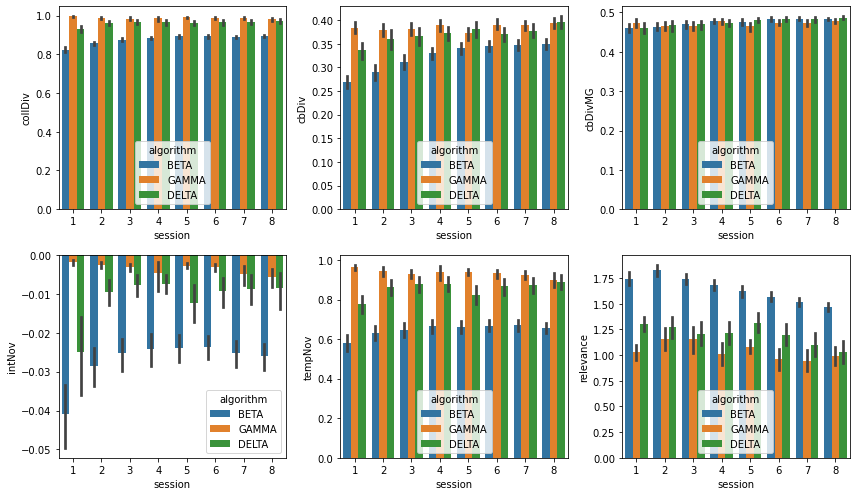

In [148]:
fig,ax = plt.subplots(2,3, figsize=(12,7))
sns.barplot(dfGroupedImpressions, x="session", y="collDiv", hue="algorithm", ax=ax[0,0])
sns.barplot(dfGroupedImpressions, x="session", y="cbDiv", hue="algorithm", ax=ax[0,1])
sns.barplot(dfGroupedImpressions, x="session", y="cbDivMG", hue="algorithm", ax=ax[0,2])

sns.barplot(dfGroupedImpressions, x="session", y="intNov", hue="algorithm", ax=ax[1,0])
sns.barplot(dfGroupedImpressions, x="session", y="tempNov", hue="algorithm", ax=ax[1,1])
sns.barplot(dfGroupedImpressions, x="session", y="relevance", hue="algorithm", ax=ax[1,2])
plt.tight_layout()

In [ ]:
dfShownSelections = dfShownSelections.reset_index()
dfShownSelections["movieId"] = dfShownSelections["movieId"].astype(int)

In [134]:
#takes couple minutes to calculate
dfGroupedSelections = dfShownSelections.groupby(["userId","session","algorithm"])["movieId"].apply(list).reset_index()
collDiv = []
cbDiv = []
cbDivMG = []
intNov = []
tempNov = []
for idx, row in dfGroupedSelections.iterrows():
    collDiv.append(intra_list_diversity(row["movieId"],collaborative_diversity))
    cbDiv.append(intra_list_diversity(row["movieId"],content_based_diversity))
    cbDivMG.append(intra_list_diversity(row["movieId"],content_based_diversity_multigenre))
    intNov.append(list_novelty(row["movieId"],inverse_popularity))
    tempNov.append(temporal_novelty(row["movieId"])[0])
    
dfGroupedSelections["collDiv"] = collDiv
dfGroupedSelections["cbDiv"] = cbDiv
dfGroupedSelections["intNov"] = intNov
dfGroupedSelections["tempNov"] = tempNov
dfGroupedSelections["cbDivMG"] = cbDivMG

In [137]:
dfGroupedSelections["numSelected"] = list(map(len,dfGroupedSelections.movieId))
relevance = []
for idx, row in dfGroupedSelections.iterrows():
    relevance.append(get_mean_relevance(row["movieId"],row["userId"],row["session"]))   
dfGroupedSelections["relevance"] = relevance

In [138]:
dfGroupedSelections

userId  session algorithm                   movieId   collDiv     cbDiv  \
0         60        1      BETA  [1339, 1489, 1595, 1793]  0.917670  0.073223   
1         60        1     GAMMA  [1339, 1793, 1816, 1856]  0.940372  0.250000   
2         60        2      BETA  [1428, 1434, 1479, 1573]  0.921123  0.399408   
3         60        2     GAMMA                    [1703]  0.981751  0.000000   
4         60        3      BETA        [1402, 1497, 1676]  0.885433  0.500000   
...      ...      ...       ...                       ...       ...       ...   
1445     185        6     DELTA  [1610, 1617, 1790, 1827]  1.000000  0.399408   
1446     185        7      BETA              [1107, 1108]  0.818583  0.295876   
1447     185        7     DELTA              [1434, 1821]  1.000000  0.146447   
1448     185        8      BETA                    [1300]  0.937712  0.000000   
1449     185        8     DELTA        [1274, 1556, 1605]  1.000000  0.500000   

        intNov   tempNov  cbDivMG  numSelected  relevance  
0    -0.018284  0.860360     0.25            4   1.568102  
1    -0.003277  0.922297     0.25            4   1.479522  
2    -0.010216  0.814189     0.50            4   1.997427  
3    -0.001762  1.000000     0.00            1   1.848575  
4    -0.008187  0.813814     0.50            3   1.966456  
...        ...       ...      ...          ...        ...  
1445 -0.000303  1.000000     0.50            4   0.632405  
1446 -0.025884  0.603103     0.50            2   1.694264  
1447 -0.002093  0.876126     0.50            2   0.928515  
1448 -0.028197  0.689189     0.00            1   1.540040  
1449 -0.004406  0.876376     0.50            3   1.113866  

[1450 rows x 11 columns]

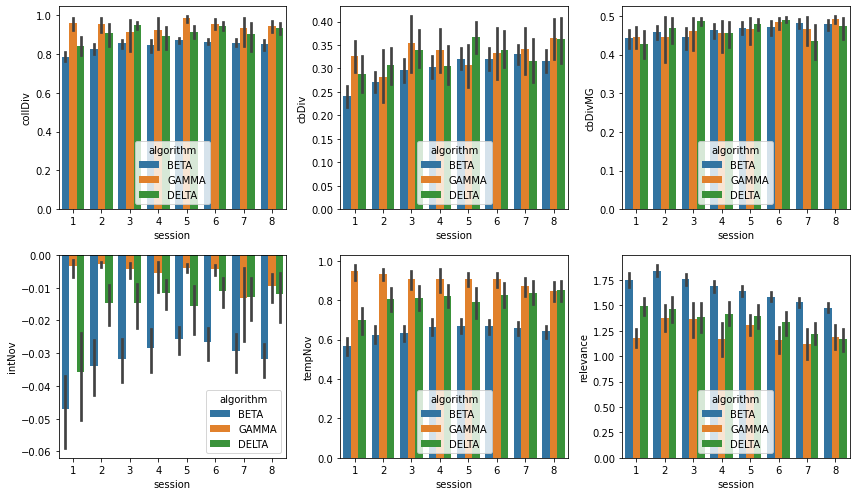

In [142]:
fig,ax = plt.subplots(2,3, figsize=(12,7))
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.numSelected>1], x="session", y="collDiv", hue="algorithm", ax=ax[0,0])
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.numSelected>1], x="session", y="cbDiv", hue="algorithm", ax=ax[0,1])
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.numSelected>1], x="session", y="cbDivMG", hue="algorithm", ax=ax[0,2])

sns.barplot(dfGroupedSelections, x="session", y="intNov", hue="algorithm", ax=ax[1,0])
sns.barplot(dfGroupedSelections, x="session", y="tempNov", hue="algorithm", ax=ax[1,1])
sns.barplot(dfGroupedSelections, x="session", y="relevance", hue="algorithm", ax=ax[1,2])
plt.tight_layout()

In [152]:
dfGroupedSelections.loc[dfGroupedSelections.algorithm == "BETA"].groupby("session")["relevance"].mean()

session
1    1.753230
2    1.842853
3    1.758916
4    1.689236
5    1.641354
6    1.584286
7    1.533224
8    1.477102
Name: relevance, dtype: float64

In [153]:
dfGroupedImpressions.loc[dfGroupedImpressions.algorithm == "BETA"].groupby("session")["relevance"].mean()

session
1    1.744050
2    1.827505
3    1.744047
4    1.682510
5    1.620734
6    1.567490
7    1.517151
8    1.469974
Name: relevance, dtype: float64

<ipython-input-156-07994effca1f>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(dfGroupedSelections.loc[dfGroupedSelections.algorithm == "BETA"], x="relevance",  common_norm=True, clip=(0,1), linestyle='--', palette=sns.color_palette())
<ipython-input-156-07994effca1f>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(dfGroupedImpressions.loc[dfGroupedImpressions.algorithm == "BETA"], x="relevance",  common_norm=True, clip=(0,1), palette=sns.color_palette("pastel"))


<AxesSubplot:xlabel='relevance', ylabel='Density'>

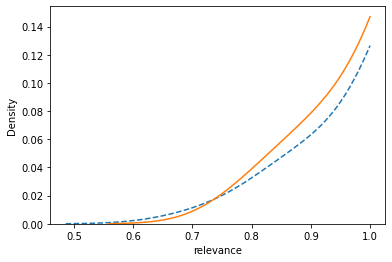

In [156]:
sns.kdeplot(dfGroupedSelections.loc[dfGroupedSelections.algorithm == "BETA"], x="relevance",  common_norm=True, clip=(0,1), linestyle='--', palette=sns.color_palette())
sns.kdeplot(dfGroupedImpressions.loc[dfGroupedImpressions.algorithm == "BETA"], x="relevance",  common_norm=True, clip=(0,1), palette=sns.color_palette("pastel"))


# Comparing results with questionnaire answers

In [157]:
dfQuestionnaire = pd.read_csv("questionnaire_responses.csv")

In [158]:
dfQuestionnaire

participation query  response  correctAnswer  locx  locy  \
0                61    q1         0            NaN     0     0   
1                63    q1         1            NaN     0     0   
2                64    q1         1            NaN     0     0   
3                60    q1         1            NaN     0     0   
4                62    q1         1            NaN     0     0   
...             ...   ...       ...            ...   ...   ...   
2047            181   q24         0            NaN     3     3   
2048            182   q24         1            NaN     3     3   
2049            177   q24         0            NaN     3     3   
2050            184   q24         0            NaN     3     3   
2051            185   q24         1            NaN     3     3   

                                               question  
0     The movies recommended to me matched my intere...  
1     The movies recommended to me matched my intere...  
2     The movies recommended to me matched my intere...  
3     The movies recommended to me matched my intere...  
4     The movies recommended to me matched my intere...  
...                                                 ...  
2047      Overall, I am satisfied with the recommender.  
2048      Overall, I am satisfied with the recommender.  
2049      Overall, I am satisfied with the recommender.  
2050      Overall, I am satisfied with the recommender.  
2051      Overall, I am satisfied with the recommender.  

[2052 rows x 7 columns]

In [159]:
dfQuestionnaire.question.unique()

array(['The movies recommended to me matched my interests.',
       'The recommended movies were novel to me.',
       'The recommended movies were diverse.',
       'The information provided for the recommended movies was sufficient to judge whether I gonna like them.',
       'I found it easy to tell the system what movies I like or dislike.',
       'I found it easy to tell the system whether it did a good job.',
       'The description of relevance, diversity, and, novelty was clear and sufficient.',
       'I understood the purpose of tweaking relevance, diversity, and novelty.',
       'The initial values of sliders already provided good recommendations.',
       'Being able to change relevance, diversity, and novelty ratios was useful for me.',
       'Overall, the effect of tweaking relevance, diversity, and novelty fulfilled my expectations.',
       'Overall, after modifying the relevance, diversity, and novelty ratios, recommendations improved.',
       'Modifying relevance,

In [160]:
dfQuestionnaire["query"].unique()

array(['q1', 'q2', 'q3', 'q4', 'q6', 'q7', 'q8', 'q9', 'q11', 'q12',
       'q13', 'q15', 'q16', 'q17', 'q18', 'q20', 'q21', 'q23', 'q24'],
      dtype=object)

In [165]:
dfGroupedImpressions

userId  session algorithm  \
0         60        1      BETA   
1         60        1     GAMMA   
2         60        2      BETA   
3         60        2     GAMMA   
4         60        3      BETA   
...      ...      ...       ...   
1691     185        6     DELTA   
1692     185        7      BETA   
1693     185        7     DELTA   
1694     185        8      BETA   
1695     185        8     DELTA   

                                                movieId   collDiv     cbDiv  \
0     [1595, 1489, 1423, 1359, 1339, 1455, 1860, 145...  0.890129  0.169690   
1     [1856, 1793, 1816, 1720, 1833, 1292, 1339, 148...  0.969161  0.233497   
2     [1756, 1702, 1434, 1726, 1573, 1494, 1428, 162...  0.914607  0.391049   
3     [1701, 1756, 1703, 1769, 1616, 1633, 1555, 161...  0.998568  0.316272   
4     [1715, 1885, 1797, 1402, 1497, 1454, 1676, 171...  0.911371  0.415268   
...                                                 ...       ...       ...   
1691  [1827, 1713, 1553, 1790, 1610, 1617, 1768, 173...  0.994839  0.395479   
1692  [1226, 1107, 1511, 1304, 1166, 1216, 1108, 665...  0.897384  0.348503   
1693  [1759, 1511, 1434, 1647, 1620, 1320, 1824, 182...  1.000000  0.373505   
1694  [1163, 1342, 258, 1326, 1106, 1386, 1084, 679,...  0.854123  0.369580   
1695  [1581, 1734, 1556, 1605, 1930, 1274, 1580, 160...  1.000000  0.398582   

        intNov   tempNov   cbDivMG  relevance  
0    -0.027569  0.838739  0.322222   1.548370  
1    -0.003800  0.888288  0.333333   1.390141  
2    -0.008679  0.900901  0.477778   2.008837  
3    -0.000848  1.000000  0.355556   1.319438  
4    -0.007589  0.888288  0.488889   1.976296  
...        ...       ...       ...        ...  
1691 -0.000705  1.000000  0.488889   0.762308  
1692 -0.021247  0.616216  0.477778   1.678634  
1693 -0.001608  0.919369  0.488889   0.698755  
1694 -0.035246  0.538739  0.500000   1.579908  
1695 -0.001806  0.962913  0.488889   0.841727  

[1696 rows x 10 columns]

In [193]:
def differencesWrtQVals(q, dfGroupedImpressions, dfGroupedSelections):
    qDF = dfQuestionnaire.loc[dfQuestionnaire["query"]==q]
    
    if q == "q4": #the only case with affinity towards neg. vals - adjust grouping accordingly
        usersWithSufficientVal = qDF.loc[qDF["response"] >= 0]["participation"].values
        usersWithInsufficientVal = qDF.loc[qDF["response"] < 0]["participation"].values        
    else:    
        usersWithSufficientVal = qDF.loc[qDF["response"] > 0]["participation"].values
        usersWithInsufficientVal = qDF.loc[qDF["response"] <= 0]["participation"].values
    res = {}
    
    res["pos_impression"] = dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithSufficientVal)].iloc[:,-6:].mean()
    res["neg_impression"] = dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithInsufficientVal)].iloc[:,-6:].mean()
    res["pos_selection"] = dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithSufficientVal)].iloc[:,-7:].mean()
    res["neg_selection"] = dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithInsufficientVal)].iloc[:,-7:].mean()
    df = pd.DataFrame(res)
    df["question"] = q
    return df

In [194]:
qs = dfQuestionnaire["query"].unique()
res = []
for q in qs:    
    res.append(differencesWrtQVals(q, dfGroupedImpressions, dfGroupedSelections))
resDF = pd.concat(res).reset_index().set_index("question")
resDF["imprDiff"] = (resDF["pos_impression"] - resDF["neg_impression"]).abs() 
resDF["selDiff"] = (resDF["pos_selection"] - resDF["neg_selection"]).abs() 
resDF = resDF.join(dfQuestionnaire[["query","question"]].drop_duplicates().set_index("query"))
resDF.head(10)

index  pos_impression  neg_impression  pos_selection  \
q1         cbDiv        0.349262        0.352755       0.253663   
q1       cbDivMG        0.474197        0.474366       0.377251   
q1       collDiv        0.925530        0.924920       0.897989   
q1        intNov       -0.017003       -0.018485      -0.020938   
q1   numSelected             NaN             NaN       3.615318   
q1     relevance        1.382477        1.394659       1.490515   
q1       tempNov        0.770153        0.771934       0.741515   
q11        cbDiv        0.347517        0.353546       0.244900   
q11      cbDivMG        0.473612        0.475110       0.369395   
q11      collDiv        0.923488        0.928088       0.894712   

     neg_selection  imprDiff   selDiff  \
q1        0.217353  0.003493  0.036310   
q1        0.330192  0.000169  0.047058   
q1        0.884850  0.000610  0.013139   
q1       -0.028860  0.001482  0.007923   
q1        3.056478       NaN  0.558839   
q1        1.521637  0.012183  0.031122   
q1        0.719649  0.001781  0.021865   
q11       0.247959  0.006028  0.003059   
q11       0.364621  0.001499  0.004774   
q11       0.896083  0.004600  0.001371   

                                              question  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q11  The initial values of sliders already provided...  
q11  The initial values of sliders already provided...  
q11  The initial values of sliders already provided...

## Difference in results of pos and neg user groups w.r.t. impressions

In [195]:
resDF.loc[resDF["index"] == "relevance"].sort_values("imprDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   relevance        1.424078        1.298941       1.517264       1.449478   
q11  relevance        1.424140        1.330137       1.516330       1.468027   
q9   relevance        1.366676        1.441870       1.486906       1.526473   
q23  relevance        1.361080        1.433887       1.473980       1.544030   
q2   relevance        1.418462        1.360523       1.520284       1.479218   
q7   relevance        1.401787        1.352712       1.506009       1.478315   
q6   relevance        1.377396        1.420488       1.484037       1.562204   
q21  relevance        1.371086        1.413589       1.488094       1.515148   
q8   relevance        1.369088        1.410536       1.480931       1.523775   
q24  relevance        1.396278        1.358125       1.503790       1.479332   
q15  relevance        1.400533        1.372842       1.517928       1.480327   
q16  relevance        1.375707        1.399464       1.493819       1.501616   
q20  relevance        1.400360        1.380167       1.523361       1.488196   
q12  relevance        1.378225        1.395628       1.499863       1.492631   
q17  relevance        1.378204        1.394141       1.490210       1.505855   
q13  relevance        1.377509        1.390956       1.490269       1.502318   
q18  relevance        1.392253        1.379217       1.509500       1.486742   
q1   relevance        1.382477        1.394659       1.490515       1.521637   
q4   relevance        1.384716        1.388606       1.495947       1.505692   

     imprDiff   selDiff                                           question  
q3   0.125137  0.067786               The recommended movies were diverse.  
q11  0.094004  0.048302  The initial values of sliders already provided...  
q9   0.075193  0.039567  I understood the purpose of tweaking relevance...  
q23  0.072807  0.070050  Appropriate values of relevance, diversity, an...  
q2   0.057939  0.041066           The recommended movies were novel to me.  
q7   0.049075  0.027694  I found it easy to tell the system whether it ...  
q6   0.043092  0.078166  I found it easy to tell the system what movies...  
q21  0.042503  0.027054  The mechanism (slider) for tweaking the object...  
q8   0.041448  0.042844  The description of relevance, diversity, and, ...  
q24  0.038152  0.024458      Overall, I am satisfied with the recommender.  
q15  0.027692  0.037601  Overall, after modifying the relevance, divers...  
q16  0.023757  0.007797  Modifying relevance, diversity, and, novelty v...  
q20  0.020193  0.035164  I was not able to describe my preferences w.r....  
q12  0.017403  0.007232  Being able to change relevance, diversity, and...  
q17  0.015937  0.015645  The mechanism (slider) provided me with suffic...  
q13  0.013447  0.012049  Overall, the effect of tweaking relevance, div...  
q18  0.013036  0.022758  The mechanism (slider) was sufficient to tell ...  
q1   0.012183  0.031122  The movies recommended to me matched my intere...  
q4   0.003889  0.009744  The information provided for the recommended m...

In [196]:
resDF.loc[resDF["index"] == "tempNov"].sort_values("imprDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   tempNov        0.795004        0.716422       0.773700       0.651004   
q7   tempNov        0.787928        0.736729       0.768284       0.672308   
q2   tempNov        0.797761        0.750459       0.772783       0.709696   
q9   tempNov        0.759281        0.805182       0.723493       0.776474   
q15  tempNov        0.793922        0.751913       0.781244       0.701802   
q4   tempNov        0.766820        0.802664       0.733901       0.763037   
q23  tempNov        0.759668        0.792594       0.729586       0.752097   
q18  tempNov        0.781146        0.761762       0.763872       0.715001   
q21  tempNov        0.766475        0.778786       0.735643       0.739703   
q12  tempNov        0.775025        0.763705       0.750115       0.717210   
q6   tempNov        0.772209        0.762896       0.743725       0.702949   
q8   tempNov        0.767989        0.774584       0.741143       0.730014   
q20  tempNov        0.774918        0.769117       0.731346       0.738849   
q13  tempNov        0.767584        0.772806       0.748923       0.727456   
q16  tempNov        0.772521        0.767521       0.744373       0.726100   
q17  tempNov        0.772650        0.767787       0.750861       0.718750   
q1   tempNov        0.770153        0.771934       0.741515       0.719649   
q24  tempNov        0.770875        0.769730       0.747236       0.710412   
q11  tempNov        0.770623        0.770422       0.738740       0.734337   

     imprDiff   selDiff                                           question  
q3   0.078582  0.122695               The recommended movies were diverse.  
q7   0.051199  0.095976  I found it easy to tell the system whether it ...  
q2   0.047302  0.063088           The recommended movies were novel to me.  
q9   0.045901  0.052981  I understood the purpose of tweaking relevance...  
q15  0.042008  0.079441  Overall, after modifying the relevance, divers...  
q4   0.035844  0.029136  The information provided for the recommended m...  
q23  0.032925  0.022510  Appropriate values of relevance, diversity, an...  
q18  0.019385  0.048871  The mechanism (slider) was sufficient to tell ...  
q21  0.012312  0.004061  The mechanism (slider) for tweaking the object...  
q12  0.011319  0.032904  Being able to change relevance, diversity, and...  
q6   0.009313  0.040776  I found it easy to tell the system what movies...  
q8   0.006596  0.011129  The description of relevance, diversity, and, ...  
q20  0.005802  0.007503  I was not able to describe my preferences w.r....  
q13  0.005222  0.021467  Overall, the effect of tweaking relevance, div...  
q16  0.004999  0.018273  Modifying relevance, diversity, and, novelty v...  
q17  0.004863  0.032111  The mechanism (slider) provided me with suffic...  
q1   0.001781  0.021865  The movies recommended to me matched my intere...  
q24  0.001145  0.036824      Overall, I am satisfied with the recommender.  
q11  0.000201  0.004403  The initial values of sliders already provided...

In [197]:
resDF.loc[resDF["index"] == "cbDiv"].sort_values("imprDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q7   cbDiv        0.356011        0.338369       0.254611       0.228598   
q3   cbDiv        0.355235        0.338483       0.257323       0.219911   
q15  cbDiv        0.357473        0.344082       0.266031       0.230310   
q9   cbDiv        0.347176        0.358768       0.245552       0.247805   
q23  cbDiv        0.346638        0.356879       0.250863       0.236432   
q18  cbDiv        0.355206        0.345727       0.259870       0.234896   
q2   cbDiv        0.354930        0.346397       0.261964       0.234059   
q4   cbDiv        0.349327        0.356001       0.244964       0.255972   
q11  cbDiv        0.347517        0.353546       0.244900       0.247959   
q12  cbDiv        0.351972        0.347044       0.251616       0.237867   
q21  cbDiv        0.348547        0.353007       0.248351       0.241571   
q17  cbDiv        0.351816        0.347676       0.258063       0.230456   
q16  cbDiv        0.348384        0.352512       0.250758       0.239315   
q8   cbDiv        0.348618        0.352241       0.244075       0.249552   
q20  cbDiv        0.352712        0.349145       0.237140       0.249115   
q1   cbDiv        0.349262        0.352755       0.253663       0.217353   
q13  cbDiv        0.351750        0.348692       0.258147       0.236547   
q24  cbDiv        0.350847        0.348017       0.260039       0.210101   
q6   cbDiv        0.350439        0.348100       0.256272       0.194971   

     imprDiff   selDiff                                           question  
q7   0.017642  0.026013  I found it easy to tell the system whether it ...  
q3   0.016752  0.037412               The recommended movies were diverse.  
q15  0.013391  0.035721  Overall, after modifying the relevance, divers...  
q9   0.011592  0.002253  I understood the purpose of tweaking relevance...  
q23  0.010241  0.014431  Appropriate values of relevance, diversity, an...  
q18  0.009479  0.024974  The mechanism (slider) was sufficient to tell ...  
q2   0.008534  0.027904           The recommended movies were novel to me.  
q4   0.006674  0.011008  The information provided for the recommended m...  
q11  0.006028  0.003059  The initial values of sliders already provided...  
q12  0.004928  0.013749  Being able to change relevance, diversity, and...  
q21  0.004460  0.006780  The mechanism (slider) for tweaking the object...  
q17  0.004140  0.027607  The mechanism (slider) provided me with suffic...  
q16  0.004128  0.011444  Modifying relevance, diversity, and, novelty v...  
q8   0.003622  0.005477  The description of relevance, diversity, and, ...  
q20  0.003567  0.011976  I was not able to describe my preferences w.r....  
q1   0.003493  0.036310  The movies recommended to me matched my intere...  
q13  0.003058  0.021600  Overall, the effect of tweaking relevance, div...  
q24  0.002830  0.049938      Overall, I am satisfied with the recommender.  
q6   0.002339  0.061301  I found it easy to tell the system what movies...

In [198]:
resDF.loc[resDF["index"] == "collDiv"].sort_values("imprDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   collDiv        0.930034        0.915141       0.908014       0.865407   
q2   collDiv        0.929501        0.922370       0.905086       0.887776   
q9   collDiv        0.923672        0.930706       0.892428       0.903560   
q7   collDiv        0.927783        0.920758       0.902162       0.881008   
q4   collDiv        0.924730        0.931159       0.896287       0.886564   
q15  collDiv        0.928894        0.922612       0.906010       0.886721   
q18  collDiv        0.928824        0.922561       0.900581       0.890915   
q21  collDiv        0.923401        0.929448       0.891587       0.902779   
q16  collDiv        0.923151        0.928821       0.891997       0.900060   
q8   collDiv        0.923336        0.928666       0.893435       0.898311   
q13  collDiv        0.922435        0.927668       0.897814       0.893227   
q6   collDiv        0.926322        0.921164       0.897662       0.883155   
q23  collDiv        0.923732        0.928775       0.892786       0.900327   
q11  collDiv        0.923488        0.928088       0.894712       0.896083   
q12  collDiv        0.926715        0.923389       0.897404       0.892037   
q24  collDiv        0.925129        0.926048       0.901225       0.879820   
q20  collDiv        0.926026        0.925193       0.893873       0.895723   
q17  collDiv        0.925123        0.925756       0.894682       0.896022   
q1   collDiv        0.925530        0.924920       0.897989       0.884850   

     imprDiff   selDiff                                           question  
q3   0.014892  0.042607               The recommended movies were diverse.  
q2   0.007132  0.017309           The recommended movies were novel to me.  
q9   0.007034  0.011131  I understood the purpose of tweaking relevance...  
q7   0.007025  0.021154  I found it easy to tell the system whether it ...  
q4   0.006429  0.009723  The information provided for the recommended m...  
q15  0.006282  0.019289  Overall, after modifying the relevance, divers...  
q18  0.006263  0.009666  The mechanism (slider) was sufficient to tell ...  
q21  0.006048  0.011192  The mechanism (slider) for tweaking the object...  
q16  0.005670  0.008062  Modifying relevance, diversity, and, novelty v...  
q8   0.005331  0.004876  The description of relevance, diversity, and, ...  
q13  0.005233  0.004587  Overall, the effect of tweaking relevance, div...  
q6   0.005158  0.014507  I found it easy to tell the system what movies...  
q23  0.005043  0.007541  Appropriate values of relevance, diversity, an...  
q11  0.004600  0.001371  The initial values of sliders already provided...  
q12  0.003326  0.005367  Being able to change relevance, diversity, and...  
q24  0.000919  0.021405      Overall, I am satisfied with the recommender.  
q20  0.000833  0.001850  I was not able to describe my preferences w.r....  
q17  0.000633  0.001340  The mechanism (slider) provided me with suffic...  
q1   0.000610  0.013139  The movies recommended to me matched my intere...

In [199]:
resDF.loc[resDF["index"] == "intNov"].sort_values("imprDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   intNov       -0.014455       -0.023672      -0.017880      -0.033590   
q9   intNov       -0.018607       -0.013380      -0.023843      -0.018890   
q7   intNov       -0.015685       -0.020513      -0.019135      -0.029704   
q18  intNov       -0.015119       -0.019150      -0.016976      -0.027163   
q15  intNov       -0.015095       -0.019102      -0.016679      -0.027273   
q2   intNov       -0.015088       -0.018975      -0.018742      -0.025508   
q6   intNov       -0.016795       -0.019752      -0.020477      -0.033198   
q16  intNov       -0.018465       -0.015587      -0.023425      -0.021343   
q24  intNov       -0.016590       -0.019102      -0.019458      -0.030672   
q23  intNov       -0.018048       -0.015858      -0.022226      -0.023311   
q13  intNov       -0.018333       -0.016552      -0.020931      -0.023898   
q20  intNov       -0.018644       -0.016896      -0.025498      -0.021612   
q8   intNov       -0.017952       -0.016330      -0.021844      -0.023816   
q1   intNov       -0.017003       -0.018485      -0.020938      -0.028860   
q4   intNov       -0.017463       -0.016131      -0.022168      -0.026096   
q12  intNov       -0.016836       -0.018070      -0.020636      -0.025510   
q21  intNov       -0.017698       -0.016568      -0.022164      -0.023439   
q11  intNov       -0.017085       -0.017663      -0.022130      -0.023260   
q17  intNov       -0.017453       -0.017157      -0.021262      -0.024316   

     imprDiff   selDiff                                           question  
q3   0.009217  0.015709               The recommended movies were diverse.  
q9   0.005227  0.004953  I understood the purpose of tweaking relevance...  
q7   0.004828  0.010569  I found it easy to tell the system whether it ...  
q18  0.004031  0.010186  The mechanism (slider) was sufficient to tell ...  
q15  0.004007  0.010595  Overall, after modifying the relevance, divers...  
q2   0.003887  0.006765           The recommended movies were novel to me.  
q6   0.002958  0.012721  I found it easy to tell the system what movies...  
q16  0.002878  0.002082  Modifying relevance, diversity, and, novelty v...  
q24  0.002512  0.011214      Overall, I am satisfied with the recommender.  
q23  0.002190  0.001085  Appropriate values of relevance, diversity, an...  
q13  0.001781  0.002968  Overall, the effect of tweaking relevance, div...  
q20  0.001747  0.003886  I was not able to describe my preferences w.r....  
q8   0.001623  0.001972  The description of relevance, diversity, and, ...  
q1   0.001482  0.007923  The movies recommended to me matched my intere...  
q4   0.001332  0.003928  The information provided for the recommended m...  
q12  0.001235  0.004875  Being able to change relevance, diversity, and...  
q21  0.001130  0.001276  The mechanism (slider) for tweaking the object...  
q11  0.000577  0.001130  The initial values of sliders already provided...  
q17  0.000296  0.003054  The mechanism (slider) provided me with suffic...

In [200]:
resDF.loc[resDF["index"] == "tempNov"].sort_values("imprDiff", ascending=False)
#interesting: the same for temporal novelty - only the difference is less substantial

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   tempNov        0.795004        0.716422       0.773700       0.651004   
q7   tempNov        0.787928        0.736729       0.768284       0.672308   
q2   tempNov        0.797761        0.750459       0.772783       0.709696   
q9   tempNov        0.759281        0.805182       0.723493       0.776474   
q15  tempNov        0.793922        0.751913       0.781244       0.701802   
q4   tempNov        0.766820        0.802664       0.733901       0.763037   
q23  tempNov        0.759668        0.792594       0.729586       0.752097   
q18  tempNov        0.781146        0.761762       0.763872       0.715001   
q21  tempNov        0.766475        0.778786       0.735643       0.739703   
q12  tempNov        0.775025        0.763705       0.750115       0.717210   
q6   tempNov        0.772209        0.762896       0.743725       0.702949   
q8   tempNov        0.767989        0.774584       0.741143       0.730014   
q20  tempNov        0.774918        0.769117       0.731346       0.738849   
q13  tempNov        0.767584        0.772806       0.748923       0.727456   
q16  tempNov        0.772521        0.767521       0.744373       0.726100   
q17  tempNov        0.772650        0.767787       0.750861       0.718750   
q1   tempNov        0.770153        0.771934       0.741515       0.719649   
q24  tempNov        0.770875        0.769730       0.747236       0.710412   
q11  tempNov        0.770623        0.770422       0.738740       0.734337   

     imprDiff   selDiff                                           question  
q3   0.078582  0.122695               The recommended movies were diverse.  
q7   0.051199  0.095976  I found it easy to tell the system whether it ...  
q2   0.047302  0.063088           The recommended movies were novel to me.  
q9   0.045901  0.052981  I understood the purpose of tweaking relevance...  
q15  0.042008  0.079441  Overall, after modifying the relevance, divers...  
q4   0.035844  0.029136  The information provided for the recommended m...  
q23  0.032925  0.022510  Appropriate values of relevance, diversity, an...  
q18  0.019385  0.048871  The mechanism (slider) was sufficient to tell ...  
q21  0.012312  0.004061  The mechanism (slider) for tweaking the object...  
q12  0.011319  0.032904  Being able to change relevance, diversity, and...  
q6   0.009313  0.040776  I found it easy to tell the system what movies...  
q8   0.006596  0.011129  The description of relevance, diversity, and, ...  
q20  0.005802  0.007503  I was not able to describe my preferences w.r....  
q13  0.005222  0.021467  Overall, the effect of tweaking relevance, div...  
q16  0.004999  0.018273  Modifying relevance, diversity, and, novelty v...  
q17  0.004863  0.032111  The mechanism (slider) provided me with suffic...  
q1   0.001781  0.021865  The movies recommended to me matched my intere...  
q24  0.001145  0.036824      Overall, I am satisfied with the recommender.  
q11  0.000201  0.004403  The initial values of sliders already provided...

## Difference in results of pos and neg user groups w.r.t. selections

In [201]:
resDF.loc[resDF["index"] == "relevance"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q6   relevance        1.377396        1.420488       1.484037       1.562204   
q23  relevance        1.361080        1.433887       1.473980       1.544030   
q3   relevance        1.424078        1.298941       1.517264       1.449478   
q11  relevance        1.424140        1.330137       1.516330       1.468027   
q8   relevance        1.369088        1.410536       1.480931       1.523775   
q2   relevance        1.418462        1.360523       1.520284       1.479218   
q9   relevance        1.366676        1.441870       1.486906       1.526473   
q15  relevance        1.400533        1.372842       1.517928       1.480327   
q20  relevance        1.400360        1.380167       1.523361       1.488196   
q1   relevance        1.382477        1.394659       1.490515       1.521637   
q7   relevance        1.401787        1.352712       1.506009       1.478315   
q21  relevance        1.371086        1.413589       1.488094       1.515148   
q24  relevance        1.396278        1.358125       1.503790       1.479332   
q18  relevance        1.392253        1.379217       1.509500       1.486742   
q17  relevance        1.378204        1.394141       1.490210       1.505855   
q13  relevance        1.377509        1.390956       1.490269       1.502318   
q4   relevance        1.384716        1.388606       1.495947       1.505692   
q16  relevance        1.375707        1.399464       1.493819       1.501616   
q12  relevance        1.378225        1.395628       1.499863       1.492631   

     imprDiff   selDiff                                           question  
q6   0.043092  0.078166  I found it easy to tell the system what movies...  
q23  0.072807  0.070050  Appropriate values of relevance, diversity, an...  
q3   0.125137  0.067786               The recommended movies were diverse.  
q11  0.094004  0.048302  The initial values of sliders already provided...  
q8   0.041448  0.042844  The description of relevance, diversity, and, ...  
q2   0.057939  0.041066           The recommended movies were novel to me.  
q9   0.075193  0.039567  I understood the purpose of tweaking relevance...  
q15  0.027692  0.037601  Overall, after modifying the relevance, divers...  
q20  0.020193  0.035164  I was not able to describe my preferences w.r....  
q1   0.012183  0.031122  The movies recommended to me matched my intere...  
q7   0.049075  0.027694  I found it easy to tell the system whether it ...  
q21  0.042503  0.027054  The mechanism (slider) for tweaking the object...  
q24  0.038152  0.024458      Overall, I am satisfied with the recommender.  
q18  0.013036  0.022758  The mechanism (slider) was sufficient to tell ...  
q17  0.015937  0.015645  The mechanism (slider) provided me with suffic...  
q13  0.013447  0.012049  Overall, the effect of tweaking relevance, div...  
q4   0.003889  0.009744  The information provided for the recommended m...  
q16  0.023757  0.007797  Modifying relevance, diversity, and, novelty v...  
q12  0.017403  0.007232  Being able to change relevance, diversity, and...

In [202]:
resDF.loc[resDF["index"] == "numSelected"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  \
q6   numSelected             NaN             NaN       3.603306   
q1   numSelected             NaN             NaN       3.615318   
q24  numSelected             NaN             NaN       3.606119   
q12  numSelected             NaN             NaN       3.363949   
q20  numSelected             NaN             NaN       3.301105   
q7   numSelected             NaN             NaN       3.427840   
q15  numSelected             NaN             NaN       3.602804   
q13  numSelected             NaN             NaN       3.600311   
q2   numSelected             NaN             NaN       3.561404   
q4   numSelected             NaN             NaN       3.488049   
q11  numSelected             NaN             NaN       3.538550   
q16  numSelected             NaN             NaN       3.538818   
q18  numSelected             NaN             NaN       3.452454   
q9   numSelected             NaN             NaN       3.515264   
q23  numSelected             NaN             NaN       3.519507   
q8   numSelected             NaN             NaN       3.477398   
q3   numSelected             NaN             NaN       3.487205   
q17  numSelected             NaN             NaN       3.510328   
q21  numSelected             NaN             NaN       3.491786   

     neg_selection  imprDiff   selDiff  \
q6        2.975000       NaN  0.628306   
q1        3.056478       NaN  0.558839   
q24       3.222772       NaN  0.383346   
q12       3.702936       NaN  0.338987   
q20       3.565257       NaN  0.264152   
q7        3.646934       NaN  0.219094   
q15       3.417079       NaN  0.185725   
q13       3.418835       NaN  0.181476   
q2        3.452005       NaN  0.109399   
q4        3.594771       NaN  0.106722   
q11       3.440620       NaN  0.097930   
q16       3.441227       NaN  0.097592   
q18       3.537594       NaN  0.085140   
q9        3.452575       NaN  0.062689   
q23       3.457983       NaN  0.061524   
q8        3.535912       NaN  0.058514   
q3        3.527650       NaN  0.040445   
q17       3.484848       NaN  0.025480   
q21       3.514706       NaN  0.022919   

                                              question  
q6   I found it easy to tell the system what movies...  
q1   The movies recommended to me matched my intere...  
q24      Overall, I am satisfied with the recommender.  
q12  Being able to change relevance, diversity, and...  
q20  I was not able to describe my preferences w.r....  
q7   I found it easy to tell the system whether it ...  
q15  Overall, after modifying the relevance, divers...  
q13  Overall, the effect of tweaking relevance, div...  
q2            The recommended movies were novel to me.  
q4   The information provided for the recommended m...  
q11  The initial values of sliders already provided...  
q16  Modifying relevance, diversity, and, novelty v...  
q18  The mechanism (slider) was sufficient to tell ...  
q9   I understood the purpose of tweaking relevance...  
q23  Appropriate values of relevance, diversity, an...  
q8   The description of relevance, diversity, and, ...  
q3                The recommended movies were diverse.  
q17  The mechanism (slider) provided me with suffic...  
q21  The mechanism (slider) for tweaking the object...

In [203]:
resDF.loc[resDF["index"] == "tempNov"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   tempNov        0.795004        0.716422       0.773700       0.651004   
q7   tempNov        0.787928        0.736729       0.768284       0.672308   
q15  tempNov        0.793922        0.751913       0.781244       0.701802   
q2   tempNov        0.797761        0.750459       0.772783       0.709696   
q9   tempNov        0.759281        0.805182       0.723493       0.776474   
q18  tempNov        0.781146        0.761762       0.763872       0.715001   
q6   tempNov        0.772209        0.762896       0.743725       0.702949   
q24  tempNov        0.770875        0.769730       0.747236       0.710412   
q12  tempNov        0.775025        0.763705       0.750115       0.717210   
q17  tempNov        0.772650        0.767787       0.750861       0.718750   
q4   tempNov        0.766820        0.802664       0.733901       0.763037   
q23  tempNov        0.759668        0.792594       0.729586       0.752097   
q1   tempNov        0.770153        0.771934       0.741515       0.719649   
q13  tempNov        0.767584        0.772806       0.748923       0.727456   
q16  tempNov        0.772521        0.767521       0.744373       0.726100   
q8   tempNov        0.767989        0.774584       0.741143       0.730014   
q20  tempNov        0.774918        0.769117       0.731346       0.738849   
q11  tempNov        0.770623        0.770422       0.738740       0.734337   
q21  tempNov        0.766475        0.778786       0.735643       0.739703   

     imprDiff   selDiff                                           question  
q3   0.078582  0.122695               The recommended movies were diverse.  
q7   0.051199  0.095976  I found it easy to tell the system whether it ...  
q15  0.042008  0.079441  Overall, after modifying the relevance, divers...  
q2   0.047302  0.063088           The recommended movies were novel to me.  
q9   0.045901  0.052981  I understood the purpose of tweaking relevance...  
q18  0.019385  0.048871  The mechanism (slider) was sufficient to tell ...  
q6   0.009313  0.040776  I found it easy to tell the system what movies...  
q24  0.001145  0.036824      Overall, I am satisfied with the recommender.  
q12  0.011319  0.032904  Being able to change relevance, diversity, and...  
q17  0.004863  0.032111  The mechanism (slider) provided me with suffic...  
q4   0.035844  0.029136  The information provided for the recommended m...  
q23  0.032925  0.022510  Appropriate values of relevance, diversity, an...  
q1   0.001781  0.021865  The movies recommended to me matched my intere...  
q13  0.005222  0.021467  Overall, the effect of tweaking relevance, div...  
q16  0.004999  0.018273  Modifying relevance, diversity, and, novelty v...  
q8   0.006596  0.011129  The description of relevance, diversity, and, ...  
q20  0.005802  0.007503  I was not able to describe my preferences w.r....  
q11  0.000201  0.004403  The initial values of sliders already provided...  
q21  0.012312  0.004061  The mechanism (slider) for tweaking the object...

In [204]:
resDF.loc[resDF["index"] == "intNov"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   intNov       -0.014455       -0.023672      -0.017880      -0.033590   
q6   intNov       -0.016795       -0.019752      -0.020477      -0.033198   
q24  intNov       -0.016590       -0.019102      -0.019458      -0.030672   
q15  intNov       -0.015095       -0.019102      -0.016679      -0.027273   
q7   intNov       -0.015685       -0.020513      -0.019135      -0.029704   
q18  intNov       -0.015119       -0.019150      -0.016976      -0.027163   
q1   intNov       -0.017003       -0.018485      -0.020938      -0.028860   
q2   intNov       -0.015088       -0.018975      -0.018742      -0.025508   
q9   intNov       -0.018607       -0.013380      -0.023843      -0.018890   
q12  intNov       -0.016836       -0.018070      -0.020636      -0.025510   
q4   intNov       -0.017463       -0.016131      -0.022168      -0.026096   
q20  intNov       -0.018644       -0.016896      -0.025498      -0.021612   
q17  intNov       -0.017453       -0.017157      -0.021262      -0.024316   
q13  intNov       -0.018333       -0.016552      -0.020931      -0.023898   
q16  intNov       -0.018465       -0.015587      -0.023425      -0.021343   
q8   intNov       -0.017952       -0.016330      -0.021844      -0.023816   
q21  intNov       -0.017698       -0.016568      -0.022164      -0.023439   
q11  intNov       -0.017085       -0.017663      -0.022130      -0.023260   
q23  intNov       -0.018048       -0.015858      -0.022226      -0.023311   

     imprDiff   selDiff                                           question  
q3   0.009217  0.015709               The recommended movies were diverse.  
q6   0.002958  0.012721  I found it easy to tell the system what movies...  
q24  0.002512  0.011214      Overall, I am satisfied with the recommender.  
q15  0.004007  0.010595  Overall, after modifying the relevance, divers...  
q7   0.004828  0.010569  I found it easy to tell the system whether it ...  
q18  0.004031  0.010186  The mechanism (slider) was sufficient to tell ...  
q1   0.001482  0.007923  The movies recommended to me matched my intere...  
q2   0.003887  0.006765           The recommended movies were novel to me.  
q9   0.005227  0.004953  I understood the purpose of tweaking relevance...  
q12  0.001235  0.004875  Being able to change relevance, diversity, and...  
q4   0.001332  0.003928  The information provided for the recommended m...  
q20  0.001747  0.003886  I was not able to describe my preferences w.r....  
q17  0.000296  0.003054  The mechanism (slider) provided me with suffic...  
q13  0.001781  0.002968  Overall, the effect of tweaking relevance, div...  
q16  0.002878  0.002082  Modifying relevance, diversity, and, novelty v...  
q8   0.001623  0.001972  The description of relevance, diversity, and, ...  
q21  0.001130  0.001276  The mechanism (slider) for tweaking the object...  
q11  0.000577  0.001130  The initial values of sliders already provided...  
q23  0.002190  0.001085  Appropriate values of relevance, diversity, an...

In [205]:
resDF.loc[resDF["index"] == "collDiv"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   collDiv        0.930034        0.915141       0.908014       0.865407   
q24  collDiv        0.925129        0.926048       0.901225       0.879820   
q7   collDiv        0.927783        0.920758       0.902162       0.881008   
q15  collDiv        0.928894        0.922612       0.906010       0.886721   
q2   collDiv        0.929501        0.922370       0.905086       0.887776   
q6   collDiv        0.926322        0.921164       0.897662       0.883155   
q1   collDiv        0.925530        0.924920       0.897989       0.884850   
q21  collDiv        0.923401        0.929448       0.891587       0.902779   
q9   collDiv        0.923672        0.930706       0.892428       0.903560   
q4   collDiv        0.924730        0.931159       0.896287       0.886564   
q18  collDiv        0.928824        0.922561       0.900581       0.890915   
q16  collDiv        0.923151        0.928821       0.891997       0.900060   
q23  collDiv        0.923732        0.928775       0.892786       0.900327   
q12  collDiv        0.926715        0.923389       0.897404       0.892037   
q8   collDiv        0.923336        0.928666       0.893435       0.898311   
q13  collDiv        0.922435        0.927668       0.897814       0.893227   
q20  collDiv        0.926026        0.925193       0.893873       0.895723   
q11  collDiv        0.923488        0.928088       0.894712       0.896083   
q17  collDiv        0.925123        0.925756       0.894682       0.896022   

     imprDiff   selDiff                                           question  
q3   0.014892  0.042607               The recommended movies were diverse.  
q24  0.000919  0.021405      Overall, I am satisfied with the recommender.  
q7   0.007025  0.021154  I found it easy to tell the system whether it ...  
q15  0.006282  0.019289  Overall, after modifying the relevance, divers...  
q2   0.007132  0.017309           The recommended movies were novel to me.  
q6   0.005158  0.014507  I found it easy to tell the system what movies...  
q1   0.000610  0.013139  The movies recommended to me matched my intere...  
q21  0.006048  0.011192  The mechanism (slider) for tweaking the object...  
q9   0.007034  0.011131  I understood the purpose of tweaking relevance...  
q4   0.006429  0.009723  The information provided for the recommended m...  
q18  0.006263  0.009666  The mechanism (slider) was sufficient to tell ...  
q16  0.005670  0.008062  Modifying relevance, diversity, and, novelty v...  
q23  0.005043  0.007541  Appropriate values of relevance, diversity, an...  
q12  0.003326  0.005367  Being able to change relevance, diversity, and...  
q8   0.005331  0.004876  The description of relevance, diversity, and, ...  
q13  0.005233  0.004587  Overall, the effect of tweaking relevance, div...  
q20  0.000833  0.001850  I was not able to describe my preferences w.r....  
q11  0.004600  0.001371  The initial values of sliders already provided...  
q17  0.000633  0.001340  The mechanism (slider) provided me with suffic...

In [206]:
resDF.loc[resDF["index"] == "cbDiv"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q6   cbDiv        0.350439        0.348100       0.256272       0.194971   
q24  cbDiv        0.350847        0.348017       0.260039       0.210101   
q3   cbDiv        0.355235        0.338483       0.257323       0.219911   
q1   cbDiv        0.349262        0.352755       0.253663       0.217353   
q15  cbDiv        0.357473        0.344082       0.266031       0.230310   
q2   cbDiv        0.354930        0.346397       0.261964       0.234059   
q17  cbDiv        0.351816        0.347676       0.258063       0.230456   
q7   cbDiv        0.356011        0.338369       0.254611       0.228598   
q18  cbDiv        0.355206        0.345727       0.259870       0.234896   
q13  cbDiv        0.351750        0.348692       0.258147       0.236547   
q23  cbDiv        0.346638        0.356879       0.250863       0.236432   
q12  cbDiv        0.351972        0.347044       0.251616       0.237867   
q20  cbDiv        0.352712        0.349145       0.237140       0.249115   
q16  cbDiv        0.348384        0.352512       0.250758       0.239315   
q4   cbDiv        0.349327        0.356001       0.244964       0.255972   
q21  cbDiv        0.348547        0.353007       0.248351       0.241571   
q8   cbDiv        0.348618        0.352241       0.244075       0.249552   
q11  cbDiv        0.347517        0.353546       0.244900       0.247959   
q9   cbDiv        0.347176        0.358768       0.245552       0.247805   

     imprDiff   selDiff                                           question  
q6   0.002339  0.061301  I found it easy to tell the system what movies...  
q24  0.002830  0.049938      Overall, I am satisfied with the recommender.  
q3   0.016752  0.037412               The recommended movies were diverse.  
q1   0.003493  0.036310  The movies recommended to me matched my intere...  
q15  0.013391  0.035721  Overall, after modifying the relevance, divers...  
q2   0.008534  0.027904           The recommended movies were novel to me.  
q17  0.004140  0.027607  The mechanism (slider) provided me with suffic...  
q7   0.017642  0.026013  I found it easy to tell the system whether it ...  
q18  0.009479  0.024974  The mechanism (slider) was sufficient to tell ...  
q13  0.003058  0.021600  Overall, the effect of tweaking relevance, div...  
q23  0.010241  0.014431  Appropriate values of relevance, diversity, an...  
q12  0.004928  0.013749  Being able to change relevance, diversity, and...  
q20  0.003567  0.011976  I was not able to describe my preferences w.r....  
q16  0.004128  0.011444  Modifying relevance, diversity, and, novelty v...  
q4   0.006674  0.011008  The information provided for the recommended m...  
q21  0.004460  0.006780  The mechanism (slider) for tweaking the object...  
q8   0.003622  0.005477  The description of relevance, diversity, and, ...  
q11  0.006028  0.003059  The initial values of sliders already provided...  
q9   0.011592  0.002253  I understood the purpose of tweaking relevance...

## The same as above, but only for MORS

In [207]:
dfGIRestr = dfGroupedImpressions.loc[dfGroupedImpressions.algorithm !="BETA"]
dfGSRestr = dfGroupedSelections.loc[dfGroupedSelections.algorithm !="BETA"]
qs = dfQuestionnaire["query"].unique()
res = []
for q in qs:    
    res.append(differencesWrtQVals(q, dfGIRestr, dfGSRestr))
resDF = pd.concat(res).reset_index().set_index("question")
resDF["imprDiff"] = (resDF["pos_impression"] - resDF["neg_impression"]).abs() 
resDF["selDiff"] = (resDF["pos_selection"] - resDF["neg_selection"]).abs() 
resDF = resDF.join(dfQuestionnaire[["query","question"]].drop_duplicates().set_index("query"))
resDF.head(10)

index  pos_impression  neg_impression  pos_selection  \
q1         cbDiv        0.377078        0.376764       0.241445   
q1       cbDivMG        0.473563        0.472464       0.339485   
q1       collDiv        0.975155        0.971818       0.939432   
q1        intNov       -0.007312       -0.007999      -0.010725   
q1   numSelected             NaN             NaN       2.921642   
q1     relevance        1.117819        1.144265       1.288887   
q1       tempNov        0.895486        0.887959       0.855307   
q11        cbDiv        0.375097        0.379706       0.228748   
q11      cbDivMG        0.473793        0.472664       0.329726   
q11      collDiv        0.971293        0.978852       0.935167   

     neg_selection  imprDiff   selDiff  \
q1        0.212214  0.000314  0.029231   
q1        0.309153  0.001099  0.030332   
q1        0.933840  0.003337  0.005591   
q1       -0.016180  0.000687  0.005455   
q1        2.661765       NaN  0.259877   
q1        1.373842  0.026445  0.084955   
q1        0.824471  0.007526  0.030836   
q11       0.245944  0.004608  0.017196   
q11       0.338907  0.001129  0.009181   
q11       0.943112  0.007558  0.007945   

                                              question  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q1   The movies recommended to me matched my intere...  
q11  The initial values of sliders already provided...  
q11  The initial values of sliders already provided...  
q11  The initial values of sliders already provided...

In [208]:
resDF.loc[resDF["index"] == "relevance"].sort_values("imprDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q11  relevance        1.177826        1.047089       1.332751       1.265118   
q3   relevance        1.160480        1.041880       1.312539       1.290050   
q6   relevance        1.108731        1.191446       1.284742       1.422623   
q9   relevance        1.108520        1.169828       1.301086       1.320263   
q2   relevance        1.154358        1.100836       1.321740       1.293527   
q4   relevance        1.118164        1.170140       1.300192       1.357543   
q12  relevance        1.104319        1.152874       1.297525       1.319302   
q23  relevance        1.107940        1.155240       1.293449       1.333300   
q7   relevance        1.139529        1.092502       1.308687       1.300386   
q24  relevance        1.135799        1.093941       1.303523       1.313124   
q8   relevance        1.107660        1.148761       1.285402       1.341209   
q16  relevance        1.111754        1.141543       1.300748       1.313971   
q1   relevance        1.117819        1.144265       1.288887       1.373842   
q13  relevance        1.114048        1.130849       1.294095       1.316162   
q20  relevance        1.134300        1.120066       1.357204       1.289576   
q21  relevance        1.118974        1.132856       1.312426       1.292776   
q15  relevance        1.129115        1.119130       1.307911       1.304559   
q18  relevance        1.119587        1.126844       1.297770       1.313197   
q17  relevance        1.123678        1.123401       1.298650       1.316294   

     imprDiff   selDiff                                           question  
q11  0.130737  0.067634  The initial values of sliders already provided...  
q3   0.118600  0.022489               The recommended movies were diverse.  
q6   0.082714  0.137882  I found it easy to tell the system what movies...  
q9   0.061308  0.019176  I understood the purpose of tweaking relevance...  
q2   0.053522  0.028213           The recommended movies were novel to me.  
q4   0.051976  0.057351  The information provided for the recommended m...  
q12  0.048556  0.021777  Being able to change relevance, diversity, and...  
q23  0.047300  0.039852  Appropriate values of relevance, diversity, an...  
q7   0.047028  0.008301  I found it easy to tell the system whether it ...  
q24  0.041858  0.009601      Overall, I am satisfied with the recommender.  
q8   0.041100  0.055807  The description of relevance, diversity, and, ...  
q16  0.029789  0.013224  Modifying relevance, diversity, and, novelty v...  
q1   0.026445  0.084955  The movies recommended to me matched my intere...  
q13  0.016801  0.022067  Overall, the effect of tweaking relevance, div...  
q20  0.014233  0.067628  I was not able to describe my preferences w.r....  
q21  0.013882  0.019650  The mechanism (slider) for tweaking the object...  
q15  0.009985  0.003352  Overall, after modifying the relevance, divers...  
q18  0.007257  0.015427  The mechanism (slider) was sufficient to tell ...  
q17  0.000276  0.017644  The mechanism (slider) provided me with suffic...

In [209]:
resDF.loc[resDF["index"] == "relevance"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q6   relevance        1.108731        1.191446       1.284742       1.422623   
q1   relevance        1.117819        1.144265       1.288887       1.373842   
q11  relevance        1.177826        1.047089       1.332751       1.265118   
q20  relevance        1.134300        1.120066       1.357204       1.289576   
q4   relevance        1.118164        1.170140       1.300192       1.357543   
q8   relevance        1.107660        1.148761       1.285402       1.341209   
q23  relevance        1.107940        1.155240       1.293449       1.333300   
q2   relevance        1.154358        1.100836       1.321740       1.293527   
q3   relevance        1.160480        1.041880       1.312539       1.290050   
q13  relevance        1.114048        1.130849       1.294095       1.316162   
q12  relevance        1.104319        1.152874       1.297525       1.319302   
q21  relevance        1.118974        1.132856       1.312426       1.292776   
q9   relevance        1.108520        1.169828       1.301086       1.320263   
q17  relevance        1.123678        1.123401       1.298650       1.316294   
q18  relevance        1.119587        1.126844       1.297770       1.313197   
q16  relevance        1.111754        1.141543       1.300748       1.313971   
q24  relevance        1.135799        1.093941       1.303523       1.313124   
q7   relevance        1.139529        1.092502       1.308687       1.300386   
q15  relevance        1.129115        1.119130       1.307911       1.304559   

     imprDiff   selDiff                                           question  
q6   0.082714  0.137882  I found it easy to tell the system what movies...  
q1   0.026445  0.084955  The movies recommended to me matched my intere...  
q11  0.130737  0.067634  The initial values of sliders already provided...  
q20  0.014233  0.067628  I was not able to describe my preferences w.r....  
q4   0.051976  0.057351  The information provided for the recommended m...  
q8   0.041100  0.055807  The description of relevance, diversity, and, ...  
q23  0.047300  0.039852  Appropriate values of relevance, diversity, an...  
q2   0.053522  0.028213           The recommended movies were novel to me.  
q3   0.118600  0.022489               The recommended movies were diverse.  
q13  0.016801  0.022067  Overall, the effect of tweaking relevance, div...  
q12  0.048556  0.021777  Being able to change relevance, diversity, and...  
q21  0.013882  0.019650  The mechanism (slider) for tweaking the object...  
q9   0.061308  0.019176  I understood the purpose of tweaking relevance...  
q17  0.000276  0.017644  The mechanism (slider) provided me with suffic...  
q18  0.007257  0.015427  The mechanism (slider) was sufficient to tell ...  
q16  0.029789  0.013224  Modifying relevance, diversity, and, novelty v...  
q24  0.041858  0.009601      Overall, I am satisfied with the recommender.  
q7   0.047028  0.008301  I found it easy to tell the system whether it ...  
q15  0.009985  0.003352  Overall, after modifying the relevance, divers...

In [210]:
resDF.loc[resDF["index"] == "numSelected"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  \
q6   numSelected             NaN             NaN       2.947183   
q24  numSelected             NaN             NaN       2.965517   
q1   numSelected             NaN             NaN       2.921642   
q12  numSelected             NaN             NaN       2.769608   
q4   numSelected             NaN             NaN       2.844113   
q16  numSelected             NaN             NaN       2.950125   
q11  numSelected             NaN             NaN       2.933661   
q9   numSelected             NaN             NaN       2.911469   
q15  numSelected             NaN             NaN       2.954098   
q17  numSelected             NaN             NaN       2.930591   
q21  numSelected             NaN             NaN       2.821978   
q2   numSelected             NaN             NaN       2.929766   
q13  numSelected             NaN             NaN       2.921824   
q7   numSelected             NaN             NaN       2.856833   
q20  numSelected             NaN             NaN       2.884146   
q3   numSelected             NaN             NaN       2.874739   
q23  numSelected             NaN             NaN       2.873638   
q18  numSelected             NaN             NaN       2.874194   
q8   numSelected             NaN             NaN       2.872340   

     neg_selection  imprDiff   selDiff  \
q6        2.442308       NaN  0.504875   
q24       2.603352       NaN  0.362165   
q1        2.661765       NaN  0.259877   
q12       3.022727       NaN  0.253119   
q4        3.086957       NaN  0.242844   
q16       2.749077       NaN  0.201047   
q11       2.769811       NaN  0.163850   
q9        2.748571       NaN  0.162897   
q15       2.798365       NaN  0.155733   
q17       2.784452       NaN  0.146139   
q21       2.967742       NaN  0.145764   
q2        2.820375       NaN  0.109391   
q13       2.824658       NaN  0.097167   
q7        2.895735       NaN  0.038902   
q20       2.864173       NaN  0.019973   
q3        2.854922       NaN  0.019817   
q23       2.859155       NaN  0.014483   
q18       2.864641       NaN  0.009553   
q8        2.863454       NaN  0.008887   

                                              question  
q6   I found it easy to tell the system what movies...  
q24      Overall, I am satisfied with the recommender.  
q1   The movies recommended to me matched my intere...  
q12  Being able to change relevance, diversity, and...  
q4   The information provided for the recommended m...  
q16  Modifying relevance, diversity, and, novelty v...  
q11  The initial values of sliders already provided...  
q9   I understood the purpose of tweaking relevance...  
q15  Overall, after modifying the relevance, divers...  
q17  The mechanism (slider) provided me with suffic...  
q21  The mechanism (slider) for tweaking the object...  
q2            The recommended movies were novel to me.  
q13  Overall, the effect of tweaking relevance, div...  
q7   I found it easy to tell the system whether it ...  
q20  I was not able to describe my preferences w.r....  
q3                The recommended movies were diverse.  
q23  Appropriate values of relevance, diversity, an...  
q18  The mechanism (slider) was sufficient to tell ...  
q8   The description of relevance, diversity, and, ...

In [211]:
resDF.loc[resDF["index"] == "intNov"].sort_values("imprDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   intNov       -0.005887       -0.010943      -0.008286      -0.020622   
q9   intNov       -0.008084       -0.005543      -0.012909      -0.008761   
q18  intNov       -0.006200       -0.008505      -0.008076      -0.015043   
q16  intNov       -0.008285       -0.006205      -0.013060      -0.010008   
q15  intNov       -0.006357       -0.008340      -0.008359      -0.014713   
q7   intNov       -0.006864       -0.008623      -0.009955      -0.015923   
q13  intNov       -0.008405       -0.006737      -0.011519      -0.012089   
q11  intNov       -0.008134       -0.006513      -0.012496      -0.010804   
q12  intNov       -0.006916       -0.008291      -0.010882      -0.013292   
q8   intNov       -0.007945       -0.006693      -0.011730      -0.011997   
q2   intNov       -0.006744       -0.007990      -0.011043      -0.012459   
q21  intNov       -0.007850       -0.006673      -0.012424      -0.010581   
q23  intNov       -0.007830       -0.006713      -0.012086      -0.011275   
q6   intNov       -0.007267       -0.008350      -0.010959      -0.016582   
q17  intNov       -0.007764       -0.007065      -0.011510      -0.012268   
q1   intNov       -0.007312       -0.007999      -0.010725      -0.016180   
q20  intNov       -0.007827       -0.007342      -0.013408      -0.011319   
q4   intNov       -0.007508       -0.007057      -0.011663      -0.013280   
q24  intNov       -0.007332       -0.007772      -0.010218      -0.016267   

     imprDiff   selDiff                                           question  
q3   0.005056  0.012336               The recommended movies were diverse.  
q9   0.002541  0.004148  I understood the purpose of tweaking relevance...  
q18  0.002305  0.006967  The mechanism (slider) was sufficient to tell ...  
q16  0.002081  0.003052  Modifying relevance, diversity, and, novelty v...  
q15  0.001983  0.006353  Overall, after modifying the relevance, divers...  
q7   0.001759  0.005968  I found it easy to tell the system whether it ...  
q13  0.001668  0.000570  Overall, the effect of tweaking relevance, div...  
q11  0.001621  0.001692  The initial values of sliders already provided...  
q12  0.001375  0.002410  Being able to change relevance, diversity, and...  
q8   0.001253  0.000267  The description of relevance, diversity, and, ...  
q2   0.001245  0.001416           The recommended movies were novel to me.  
q21  0.001177  0.001843  The mechanism (slider) for tweaking the object...  
q23  0.001117  0.000810  Appropriate values of relevance, diversity, an...  
q6   0.001083  0.005623  I found it easy to tell the system what movies...  
q17  0.000699  0.000758  The mechanism (slider) provided me with suffic...  
q1   0.000687  0.005455  The movies recommended to me matched my intere...  
q20  0.000485  0.002089  I was not able to describe my preferences w.r....  
q4   0.000451  0.001617  The information provided for the recommended m...  
q24  0.000439  0.006049      Overall, I am satisfied with the recommender.

In [212]:
resDF.loc[resDF["index"] == "intNov"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   intNov       -0.005887       -0.010943      -0.008286      -0.020622   
q18  intNov       -0.006200       -0.008505      -0.008076      -0.015043   
q15  intNov       -0.006357       -0.008340      -0.008359      -0.014713   
q24  intNov       -0.007332       -0.007772      -0.010218      -0.016267   
q7   intNov       -0.006864       -0.008623      -0.009955      -0.015923   
q6   intNov       -0.007267       -0.008350      -0.010959      -0.016582   
q1   intNov       -0.007312       -0.007999      -0.010725      -0.016180   
q9   intNov       -0.008084       -0.005543      -0.012909      -0.008761   
q16  intNov       -0.008285       -0.006205      -0.013060      -0.010008   
q12  intNov       -0.006916       -0.008291      -0.010882      -0.013292   
q20  intNov       -0.007827       -0.007342      -0.013408      -0.011319   
q21  intNov       -0.007850       -0.006673      -0.012424      -0.010581   
q11  intNov       -0.008134       -0.006513      -0.012496      -0.010804   
q4   intNov       -0.007508       -0.007057      -0.011663      -0.013280   
q2   intNov       -0.006744       -0.007990      -0.011043      -0.012459   
q23  intNov       -0.007830       -0.006713      -0.012086      -0.011275   
q17  intNov       -0.007764       -0.007065      -0.011510      -0.012268   
q13  intNov       -0.008405       -0.006737      -0.011519      -0.012089   
q8   intNov       -0.007945       -0.006693      -0.011730      -0.011997   

     imprDiff   selDiff                                           question  
q3   0.005056  0.012336               The recommended movies were diverse.  
q18  0.002305  0.006967  The mechanism (slider) was sufficient to tell ...  
q15  0.001983  0.006353  Overall, after modifying the relevance, divers...  
q24  0.000439  0.006049      Overall, I am satisfied with the recommender.  
q7   0.001759  0.005968  I found it easy to tell the system whether it ...  
q6   0.001083  0.005623  I found it easy to tell the system what movies...  
q1   0.000687  0.005455  The movies recommended to me matched my intere...  
q9   0.002541  0.004148  I understood the purpose of tweaking relevance...  
q16  0.002081  0.003052  Modifying relevance, diversity, and, novelty v...  
q12  0.001375  0.002410  Being able to change relevance, diversity, and...  
q20  0.000485  0.002089  I was not able to describe my preferences w.r....  
q21  0.001177  0.001843  The mechanism (slider) for tweaking the object...  
q11  0.001621  0.001692  The initial values of sliders already provided...  
q4   0.000451  0.001617  The information provided for the recommended m...  
q2   0.001245  0.001416           The recommended movies were novel to me.  
q23  0.001117  0.000810  Appropriate values of relevance, diversity, an...  
q17  0.000699  0.000758  The mechanism (slider) provided me with suffic...  
q13  0.001668  0.000570  Overall, the effect of tweaking relevance, div...  
q8   0.001253  0.000267  The description of relevance, diversity, and, ...

In [213]:
resDF.loc[resDF["index"] == "tempNov"].sort_values("imprDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   tempNov        0.908832        0.860716       0.880883       0.770102   
q7   tempNov        0.905692        0.870832       0.873065       0.796633   
q15  tempNov        0.910322        0.880733       0.885739       0.818589   
q9   tempNov        0.887375        0.913783       0.838507       0.879056   
q2   tempNov        0.908994        0.882683       0.870540       0.831854   
q6   tempNov        0.898003        0.874849       0.857154       0.804895   
q23  tempNov        0.887333        0.907079       0.840354       0.867842   
q11  tempNov        0.885920        0.905031       0.842331       0.859412   
q18  tempNov        0.902815        0.886436       0.875216       0.826673   
q12  tempNov        0.900305        0.884022       0.860932       0.830730   
q21  tempNov        0.889644        0.902391       0.840353       0.867336   
q1   tempNov        0.895486        0.887959       0.855307       0.824471   
q4   tempNov        0.893412        0.897661       0.849129       0.848522   
q13  tempNov        0.891644        0.895546       0.858022       0.841534   
q20  tempNov        0.896599        0.892960       0.840432       0.851854   
q17  tempNov        0.894695        0.892755       0.857311       0.837734   
q16  tempNov        0.894442        0.892955       0.851726       0.845131   
q8   tempNov        0.894169        0.893351       0.854569       0.839718   
q24  tempNov        0.893897        0.893746       0.859348       0.820748   

     imprDiff   selDiff                                           question  
q3   0.048116  0.110781               The recommended movies were diverse.  
q7   0.034860  0.076432  I found it easy to tell the system whether it ...  
q15  0.029589  0.067150  Overall, after modifying the relevance, divers...  
q9   0.026408  0.040549  I understood the purpose of tweaking relevance...  
q2   0.026311  0.038686           The recommended movies were novel to me.  
q6   0.023155  0.052260  I found it easy to tell the system what movies...  
q23  0.019745  0.027488  Appropriate values of relevance, diversity, an...  
q11  0.019111  0.017081  The initial values of sliders already provided...  
q18  0.016379  0.048543  The mechanism (slider) was sufficient to tell ...  
q12  0.016283  0.030202  Being able to change relevance, diversity, and...  
q21  0.012747  0.026983  The mechanism (slider) for tweaking the object...  
q1   0.007526  0.030836  The movies recommended to me matched my intere...  
q4   0.004249  0.000607  The information provided for the recommended m...  
q13  0.003902  0.016488  Overall, the effect of tweaking relevance, div...  
q20  0.003639  0.011422  I was not able to describe my preferences w.r....  
q17  0.001940  0.019578  The mechanism (slider) provided me with suffic...  
q16  0.001487  0.006595  Modifying relevance, diversity, and, novelty v...  
q8   0.000818  0.014851  The description of relevance, diversity, and, ...  
q24  0.000152  0.038600      Overall, I am satisfied with the recommender.

In [214]:
resDF.loc[resDF["index"] == "tempNov"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   tempNov        0.908832        0.860716       0.880883       0.770102   
q7   tempNov        0.905692        0.870832       0.873065       0.796633   
q15  tempNov        0.910322        0.880733       0.885739       0.818589   
q6   tempNov        0.898003        0.874849       0.857154       0.804895   
q18  tempNov        0.902815        0.886436       0.875216       0.826673   
q9   tempNov        0.887375        0.913783       0.838507       0.879056   
q2   tempNov        0.908994        0.882683       0.870540       0.831854   
q24  tempNov        0.893897        0.893746       0.859348       0.820748   
q1   tempNov        0.895486        0.887959       0.855307       0.824471   
q12  tempNov        0.900305        0.884022       0.860932       0.830730   
q23  tempNov        0.887333        0.907079       0.840354       0.867842   
q21  tempNov        0.889644        0.902391       0.840353       0.867336   
q17  tempNov        0.894695        0.892755       0.857311       0.837734   
q11  tempNov        0.885920        0.905031       0.842331       0.859412   
q13  tempNov        0.891644        0.895546       0.858022       0.841534   
q8   tempNov        0.894169        0.893351       0.854569       0.839718   
q20  tempNov        0.896599        0.892960       0.840432       0.851854   
q16  tempNov        0.894442        0.892955       0.851726       0.845131   
q4   tempNov        0.893412        0.897661       0.849129       0.848522   

     imprDiff   selDiff                                           question  
q3   0.048116  0.110781               The recommended movies were diverse.  
q7   0.034860  0.076432  I found it easy to tell the system whether it ...  
q15  0.029589  0.067150  Overall, after modifying the relevance, divers...  
q6   0.023155  0.052260  I found it easy to tell the system what movies...  
q18  0.016379  0.048543  The mechanism (slider) was sufficient to tell ...  
q9   0.026408  0.040549  I understood the purpose of tweaking relevance...  
q2   0.026311  0.038686           The recommended movies were novel to me.  
q24  0.000152  0.038600      Overall, I am satisfied with the recommender.  
q1   0.007526  0.030836  The movies recommended to me matched my intere...  
q12  0.016283  0.030202  Being able to change relevance, diversity, and...  
q23  0.019745  0.027488  Appropriate values of relevance, diversity, an...  
q21  0.012747  0.026983  The mechanism (slider) for tweaking the object...  
q17  0.001940  0.019578  The mechanism (slider) provided me with suffic...  
q11  0.019111  0.017081  The initial values of sliders already provided...  
q13  0.003902  0.016488  Overall, the effect of tweaking relevance, div...  
q8   0.000818  0.014851  The description of relevance, diversity, and, ...  
q20  0.003639  0.011422  I was not able to describe my preferences w.r....  
q16  0.001487  0.006595  Modifying relevance, diversity, and, novelty v...  
q4   0.004249  0.000607  The information provided for the recommended m...

In [216]:
resDF.loc[resDF["index"] == "collDiv"].sort_values("selDiff", ascending=False)

index  pos_impression  neg_impression  pos_selection  neg_selection  \
q3   collDiv        0.977985        0.966569       0.951269       0.906113   
q6   collDiv        0.975871        0.967837       0.941239       0.922250   
q15  collDiv        0.977930        0.971643       0.948663       0.929688   
q21  collDiv        0.973154        0.977021       0.932502       0.950456   
q24  collDiv        0.974052        0.975348       0.942994       0.925372   
q2   collDiv        0.976216        0.973113       0.947242       0.931132   
q9   collDiv        0.973502        0.977289       0.934426       0.949302   
q7   collDiv        0.976259        0.970876       0.942236       0.929699   
q18  collDiv        0.978754        0.970853       0.944328       0.933138   
q8   collDiv        0.973296        0.976229       0.934834       0.944187   
q23  collDiv        0.973925        0.975457       0.935447       0.944448   
q11  collDiv        0.971293        0.978852       0.935167       0.943112   
q17  collDiv        0.974357        0.974527       0.935322       0.942394   
q1   collDiv        0.975155        0.971818       0.939432       0.933840   
q12  collDiv        0.976623        0.971090       0.940391       0.935069   
q16  collDiv        0.973474        0.975889       0.936437       0.941057   
q4   collDiv        0.974751        0.971667       0.938730       0.934543   
q13  collDiv        0.972486        0.975922       0.939045       0.937674   
q20  collDiv        0.974501        0.974408       0.939174       0.938018   

     imprDiff   selDiff                                           question  
q3   0.011415  0.045156               The recommended movies were diverse.  
q6   0.008034  0.018988  I found it easy to tell the system what movies...  
q15  0.006287  0.018975  Overall, after modifying the relevance, divers...  
q21  0.003868  0.017954  The mechanism (slider) for tweaking the object...  
q24  0.001296  0.017622      Overall, I am satisfied with the recommender.  
q2   0.003103  0.016109           The recommended movies were novel to me.  
q9   0.003788  0.014877  I understood the purpose of tweaking relevance...  
q7   0.005383  0.012537  I found it easy to tell the system whether it ...  
q18  0.007901  0.011190  The mechanism (slider) was sufficient to tell ...  
q8   0.002933  0.009353  The description of relevance, diversity, and, ...  
q23  0.001532  0.009001  Appropriate values of relevance, diversity, an...  
q11  0.007558  0.007945  The initial values of sliders already provided...  
q17  0.000169  0.007072  The mechanism (slider) provided me with suffic...  
q1   0.003337  0.005591  The movies recommended to me matched my intere...  
q12  0.005534  0.005322  Being able to change relevance, diversity, and...  
q16  0.002415  0.004620  Modifying relevance, diversity, and, novelty v...  
q4   0.003083  0.004187  The information provided for the recommended m...  
q13  0.003436  0.001371  Overall, the effect of tweaking relevance, div...  
q20  0.000093  0.001156  I was not able to describe my preferences w.r....

(array([ 8.,  9., 12., 31., 23., 15.,  1.,  1.,  0.,  2.]),
 array([0.15384615, 0.21346154, 0.27307692, 0.33269231, 0.39230769,
        0.45192308, 0.51153846, 0.57115385, 0.63076923, 0.69038462,
        0.75      ]),
 <BarContainer object of 10 artists>)

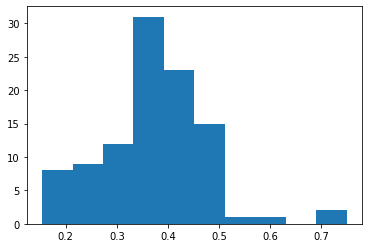

In [226]:
betaSel = dfGroupedSelections.loc[dfGroupedSelections.algorithm=="BETA"].groupby("userId")["numSelected"].sum()
morsSel = dfGroupedSelections.loc[dfGroupedSelections.algorithm!="BETA"].groupby("userId")["numSelected"].sum()
userDiff = morsSel / (morsSel + betaSel)

userDiff.reset_index().to_csv("morsVSsingleObjSelections.csv")
plt.hist(userDiff)

(array([ 6., 12., 11., 15., 16., 12., 10.,  5.,  8.,  7.]),
 array([11. , 19.3, 27.6, 35.9, 44.2, 52.5, 60.8, 69.1, 77.4, 85.7, 94. ]),
 <BarContainer object of 10 artists>)

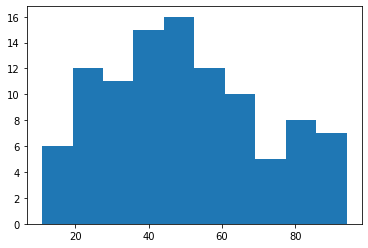

In [227]:
userDiff = morsSel + betaSel

userDiff.reset_index().to_csv("totalSelections.csv")
plt.hist(userDiff)

# User weights vs. selections

In [235]:
dfWeights.columns = ["userId", "relevanceWeight","diversityWeight","noveltyWeight","timestamp","session"]
dfWeights

userId  relevanceWeight  diversityWeight  noveltyWeight   timestamp  \
0       61         0.489443         0.245096       0.265461  1681411282   
1       61         0.471467         0.320000       0.208533  1681411369   
2       61         0.387059         0.440000       0.172941  1681411410   
3       61         0.338313         0.381687       0.280000  1681411449   
4       61         0.489443         0.245096       0.265461  1681411483   
..     ...              ...              ...            ...         ...   
846    185         0.520000         0.340645       0.139355  1681822765   
847    185         0.324388         0.328335       0.347277  1681822847   
848    185         0.140805         0.560000       0.299195  1681822902   
849    185         0.140000         0.560000       0.300000  1681822970   
850    185         0.140000         0.560000       0.300000  1681823021   

    session  
0         1  
1         2  
2         3  
3         4  
4         5  
..      ...  
846       4  
847       5  
848       6  
849       7  
850       8  

[851 rows x 6 columns]

In [244]:
weightsCrossSelections = dfGroupedSelections.set_index(["userId","session"]).join(dfWeights.set_index(["userId","session"]))
weightsCrossSelections

algorithm                   movieId   collDiv     cbDiv  \
userId session                                                           
60     1            BETA  [1339, 1489, 1595, 1793]  0.917670  0.073223   
       1           GAMMA  [1339, 1793, 1816, 1856]  0.940372  0.250000   
       2            BETA  [1428, 1434, 1479, 1573]  0.921123  0.399408   
       2           GAMMA                    [1703]  0.981751  0.000000   
       3            BETA        [1402, 1497, 1676]  0.885433  0.500000   
...                  ...                       ...       ...       ...   
185    6           DELTA  [1610, 1617, 1790, 1827]  1.000000  0.399408   
       7            BETA              [1107, 1108]  0.818583  0.295876   
       7           DELTA              [1434, 1821]  1.000000  0.146447   
       8            BETA                    [1300]  0.937712  0.000000   
       8           DELTA        [1274, 1556, 1605]  1.000000  0.500000   

                  intNov   tempNov  cbDivMG  numSelected  relevance  \
userId session                                                        
60     1       -0.018284  0.860360     0.25            4   1.568102   
       1       -0.003277  0.922297     0.25            4   1.479522   
       2       -0.010216  0.814189     0.50            4   1.997427   
       2       -0.001762  1.000000     0.00            1   1.848575   
       3       -0.008187  0.813814     0.50            3   1.966456   
...                  ...       ...      ...          ...        ...   
185    6       -0.000303  1.000000     0.50            4   0.632405   
       7       -0.025884  0.603103     0.50            2   1.694264   
       7       -0.002093  0.876126     0.50            2   0.928515   
       8       -0.028197  0.689189     0.00            1   1.540040   
       8       -0.004406  0.876376     0.50            3   1.113866   

                relevanceWeight  diversityWeight  noveltyWeight   timestamp  
userId session                                                               
60     1               0.751590         0.121887       0.126523  1681411803  
       1               0.751590         0.121887       0.126523  1681411803  
       2               0.474687         0.145313       0.380000  1681412092  
       2               0.474687         0.145313       0.380000  1681412092  
       3               0.390000         0.410964       0.199036  1681412171  
...                         ...              ...            ...         ...  
185    6               0.140805         0.560000       0.299195  1681822902  
       7               0.140000         0.560000       0.300000  1681822970  
       7               0.140000         0.560000       0.300000  1681822970  
       8               0.140000         0.560000       0.300000  1681823021  
       8               0.140000         0.560000       0.300000  1681823021  

[1456 rows x 13 columns]

<ipython-input-245-16ad3853931d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weightsCrossSelectionsNB["relRound"] = (weightsCrossSelectionsNB["relevanceWeight"]*5).astype(int)


<AxesSubplot:xlabel='relRound', ylabel='numSelected'>

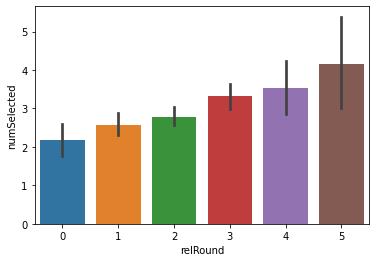

In [245]:
weightsCrossSelectionsNB = weightsCrossSelections.loc[weightsCrossSelections.algorithm != "BETA"]
weightsCrossSelectionsNB["relRound"] = (weightsCrossSelectionsNB["relevanceWeight"]*5).astype(int)
sns.barplot(weightsCrossSelectionsNB, x="relRound", y="numSelected")

#the higher selected relevance, the more selections

<ipython-input-248-1d5ca458cb9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weightsCrossSelectionsNB["relRound"] = (weightsCrossSelectionsNB["diversityWeight"]*5).astype(int)


<AxesSubplot:xlabel='relRound', ylabel='numSelected'>

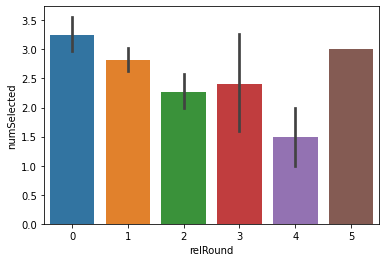

In [248]:
weightsCrossSelectionsNB = weightsCrossSelections.loc[weightsCrossSelections.algorithm != "BETA"]
weightsCrossSelectionsNB["relRound"] = (weightsCrossSelectionsNB["diversityWeight"]*5).astype(int)
sns.barplot(weightsCrossSelectionsNB, x="relRound", y="numSelected")

<ipython-input-249-56831af776f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weightsCrossSelectionsNB["relRound"] = (weightsCrossSelectionsNB["noveltyWeight"]*5).astype(int)


<AxesSubplot:xlabel='relRound', ylabel='numSelected'>

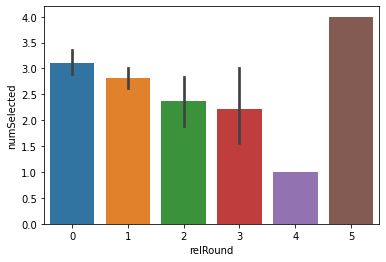

In [249]:
weightsCrossSelectionsNB = weightsCrossSelections.loc[weightsCrossSelections.algorithm != "BETA"]
weightsCrossSelectionsNB["relRound"] = (weightsCrossSelectionsNB["noveltyWeight"]*5).astype(int)
sns.barplot(weightsCrossSelectionsNB, x="relRound", y="numSelected")

<ipython-input-247-88365c1e5a6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weightsCrossSelectionsB["relRound"] = (weightsCrossSelectionsB["relevanceWeight"]*5).astype(int)


<AxesSubplot:xlabel='relRound', ylabel='numSelected'>

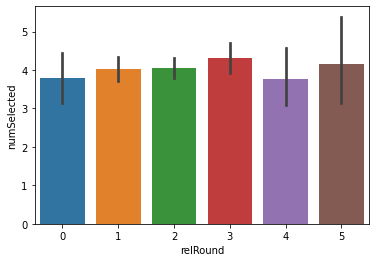

In [247]:
weightsCrossSelectionsB = weightsCrossSelections.loc[weightsCrossSelections.algorithm == "BETA"]
weightsCrossSelectionsB["relRound"] = (weightsCrossSelectionsB["relevanceWeight"]*5).astype(int)
sns.barplot(weightsCrossSelectionsB, x="relRound", y="numSelected")

## Diversity / novelty while users are divided to those with (in)sufficient reported diversity

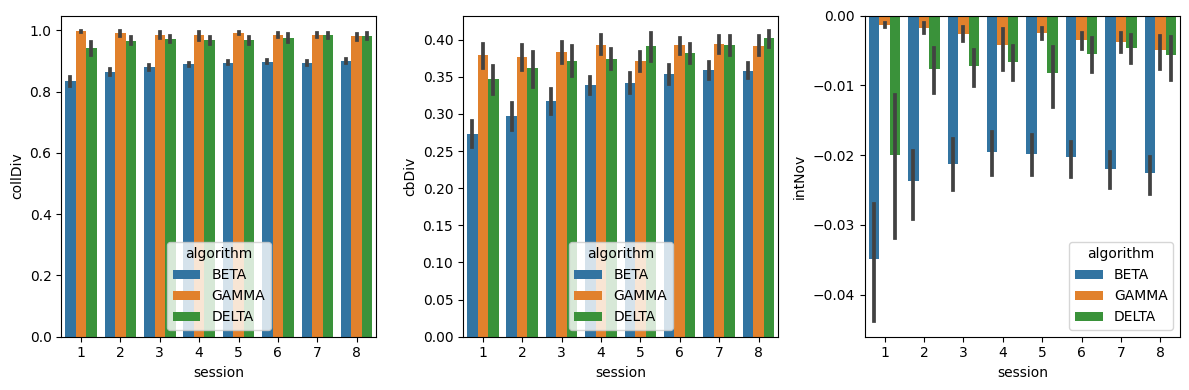

In [93]:
#sufficient diversity
fig,ax = plt.subplots(1,3, figsize=(12,4))
sns.barplot(dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithSufficientDiversity)], x="session", y="collDiv", hue="algorithm", ax=ax[0])
sns.barplot(dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithSufficientDiversity)], x="session", y="cbDiv", hue="algorithm", ax=ax[1])
sns.barplot(dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithSufficientDiversity)], x="session", y="intNov", hue="algorithm", ax=ax[2])
plt.tight_layout()

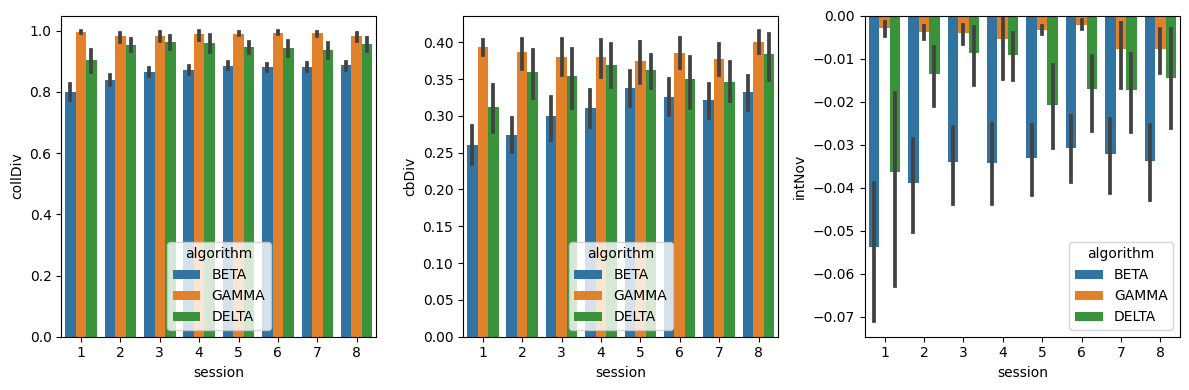

In [94]:
#insufficient diversity
fig,ax = plt.subplots(1,3, figsize=(12,4))
sns.barplot(dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithInsufficientDiversity)], x="session", y="collDiv", hue="algorithm", ax=ax[0])
sns.barplot(dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithInsufficientDiversity)], x="session", y="cbDiv", hue="algorithm", ax=ax[1])
sns.barplot(dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithInsufficientDiversity)], x="session", y="intNov", hue="algorithm", ax=ax[2])
plt.tight_layout()

In [100]:
dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithSufficientDiversity)].iloc[:,-3:].mean()

collDiv    0.930034
cbDiv      0.355235
intNov    -0.014455
dtype: float64

In [101]:
dfGroupedImpressions.loc[dfGroupedImpressions.userId.isin(usersWithInsufficientDiversity)].iloc[:,-3:].mean()

collDiv    0.915141
cbDiv      0.338483
intNov    -0.023672
dtype: float64

- indeed, values are a bit lower if users reported the decrease...

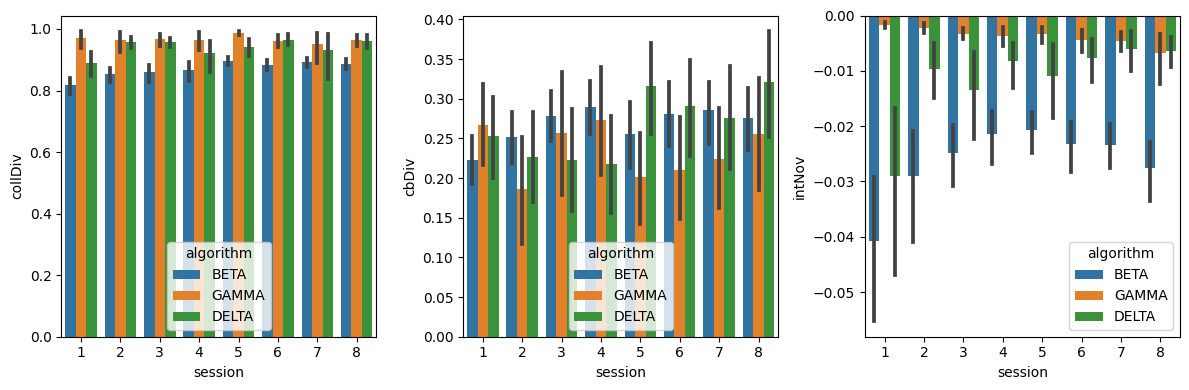

In [92]:
fig,ax = plt.subplots(1,3, figsize=(12,4))
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithSufficientDiversity)], x="session", y="collDiv", hue="algorithm", ax=ax[0])
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithSufficientDiversity)], x="session", y="cbDiv", hue="algorithm", ax=ax[1])
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithSufficientDiversity)], x="session", y="intNov", hue="algorithm", ax=ax[2])
plt.tight_layout()

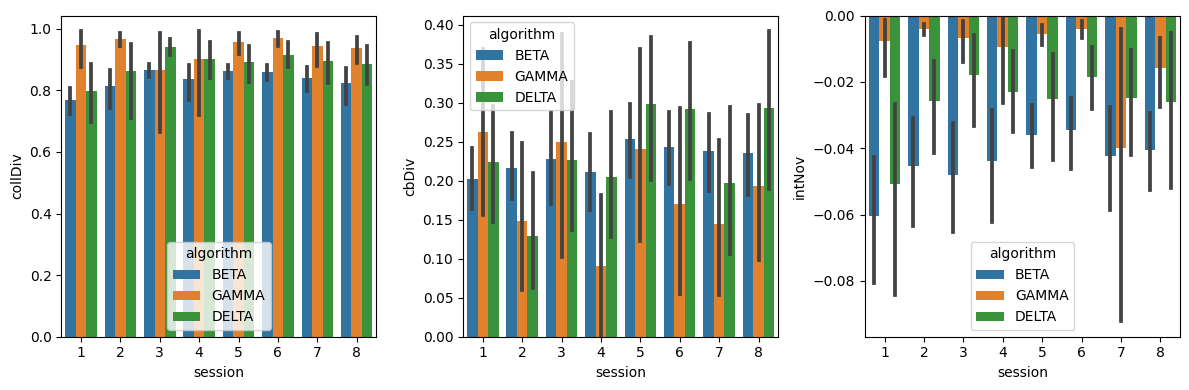

In [102]:
fig,ax = plt.subplots(1,3, figsize=(12,4))
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithInsufficientDiversity)], x="session", y="collDiv", hue="algorithm", ax=ax[0])
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithInsufficientDiversity)], x="session", y="cbDiv", hue="algorithm", ax=ax[1])
sns.barplot(dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithInsufficientDiversity)], x="session", y="intNov", hue="algorithm", ax=ax[2])
plt.tight_layout()

In [103]:
dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithSufficientDiversity)].iloc[:,-3:].mean()

collDiv    0.908014
cbDiv      0.257323
intNov    -0.017880
dtype: float64

In [104]:
dfGroupedSelections.loc[dfGroupedSelections.userId.isin(usersWithInsufficientDiversity)].iloc[:,-3:].mean()

collDiv    0.865407
cbDiv      0.219911
intNov    -0.033590
dtype: float64

- differences are quite a bit more notable for selections than for impressions